### Funções base

In [ ]:
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import csv
import multiprocessing as mp
import copy

In [ ]:
def readFile(fileName):
  file = open(fileName)
  csvreader = csv.reader(file)
  header = []
  header = next(csvreader)
  data = []
  for row in csvreader:
    data.append(row)
  file.close
  return data

In [ ]:
def stdDev(list):
  mean = sum(list)/len(list)
  return math.sqrt(sum((x - mean)**2 for x in list) / len(list))

# **Trabalho Prático I - Regressão Simbólica**

Pedro Figueiredo Cipriano

# **1 - Introdução**

Neste trabalho procura-se por uma solução para o problema da regressão simbólica. Esse problema consiste em encontrar uma função que seja uma boa aproximação para um conjunto de pontos dados. Para tanto, estipula-se o que se espera da função e, a partir disso, gera-se indivíduos aleatoriamente em conformidade com esse modelo utilizando a ideia de uma gramática. Depois seleciona-se e modifica-se esses indivíduos gerando uma nova população. Espera-se que a cada geração as soluções se tornem progressivamente melhores minimizando a distância das suas saídas aos pontos dados.

Para atingir esse objetivo, produziu-se um programa com diversos parâmetros modularizáveis afim de possibilitar uma maior exploração dos possíveis efeitos do algoritmo. Se destacam os parâmetros: tamanho da população, tamanho do torneio, probabilidade de cruzamento, probabilidade de mutação, elistismo de operadores ou não e porcentagem da população preservada. A definição e o efeito desses parâmetros serão melhor explicados na próxima seção.

# **2 - Decisões de implementação**
Nessa seção olhamos para implementação do programa e as decisões tomadas em cada pedaço do código. De forma breve, podemos dizer que utilizamos uma estratégia geracional na qual os indíviduos representados por árvores são gerados a partir de crossover e mutação de pais selecionados por torneio. Caso a probabilidade de mutação + crossover seja menor que 1, geramos indivíduos aleatórios na nova população. A inicialização desses indivíduos bem como da população inicial se dá utilizando-se basicamente a estratégia "ramped half and half".

## 2.1 - Classe Árvore

Inicialmente define-se a classe Node, que servirá como base para nossa representação em árvores binárias de cada indivíduo, assim como funções básicas que nossa classe utilizará. Essas funções consistem na cópia de uma árvore nó por nó e na impressão das expressões guardadas. Definimos também uma função para recalcular a altura e a quantidade de filhos e outra para escolhermos um nó aleatório da árvore. A utilidade dessas duas últimas funções ficará mais clara nas funções que executam os operadores genéticos.

In [ ]:
class Node:
  def __init__(self, data):
    self.data = data
    self.height = 1
    self.children = 0
    self.left = -1
    self.right = -1

In [ ]:
def copyTree(destinationRoot, rootToCopy):
  destinationRoot.data = rootToCopy.data
  destinationRoot.height = rootToCopy.height
  destinationRoot.children = rootToCopy.children
  if(rootToCopy.left!=-1):
    destinationRoot.left = Node(0)
    copyTree(destinationRoot.left, rootToCopy.left)
  else:
    destinationRoot.left = -1
  if(rootToCopy.right!=-1):
    destinationRoot.right = Node(0)
    copyTree(destinationRoot.right, rootToCopy.right)
  else:
    destinationRoot.right = -1

In [ ]:
def treeString(root):
  if(root.left!=-1 and root.right!=1): #operador
   return "(" + treeString(root.left) + root.data + treeString(root.right) + ")"
  elif(root.right!=-1 and root.left==-1): #sin ou cos
   return root.data + "(" + treeString(root.right) + ")"
  elif(root.data>=1): #variavel
     return "X" + str(root.data)
  else: #terminal
    return str(root.data)

def print_tree(root):
  print(treeString(root))

In [ ]:
def recalcHeightAndChildren(node):
  if(node.height > 1):
    if(node.left!=-1):
      recalcHeightAndChildren(node.left)
      recalcHeightAndChildren(node.right)
      node.height = max(node.left.height, node.right.height)+1
      node.children = node.left.children+node.right.children + 2

    else:
      recalcHeightAndChildren(node.right)
      node.height = node.right.height + 1
      node.children = node.right.children + 1

In [ ]:
def randomNodeFinder(root, count, height_permit):
  if(height_permit == 1):
    return root, height_permit
  if root.left == -1:
    if count and root.height>1:
     return randomNodeFinder(root.right, count - 1, height_permit-1)
    else:
      return root, height_permit
  elif count == root.left.children:
    return root, height_permit
  elif count < root.left.children:
      return randomNodeFinder(root.left, count, height_permit-1)
  else:
      return randomNodeFinder(root.right, count - root.left.children - 1, height_permit-1)


def randomNode(root, height_permit):
  return randomNodeFinder(root, rd.randint(0, root.children), height_permit)

## 2.2 - Classe Indivíduo


Essa classe se resume em agregar a árvore do indivíduo com sua fitness. Faz-se também o overload dos operadores comparação e da adição.

In [ ]:
class solution:
  def __init__(self,tree):
    self.tree = tree
    self.fitness = -500
  def __gt__(self, other):
        if(self.fitness>other.fitness):
            return True
        else:
            return False
  def __lt__(self, other):
        if(self.fitness<other.fitness):
            return True
        else:
            return False
  def __eq__(self, other):
        if(self.fitness == other.fitness):
            return True
        else:
            return False
  def __add__(self, other):
          return float(self.fitness + other.fitness)

## 2.3 - Novas Soluções e inicialização da população

A partir da classe definida anteriormente, representa-se os indivíduos utilizando uma gramática simples. Como esperamos que nossa função use as operações básicas ( * , + , - , / ) e as funções seno e cosseno, os nós internos da árvore do indivíduo serão uma dentre essas seis possibilidades. Naturalmente, as folhas terão que ser as variáveis do problema ou números, os chamados terminais. Para os números, utilizamos um float entre -1 e 1.

Sendo assim, gera-se as árvores utilizando-se ambos métodos "grow" e "full" por meio da função newSolution. O primeiro desses escolhe aleatoriamente qual informação o nó irá guardar e gera as subárvores dos seus filhos da mesma maneira(se existirem). O segundo gera uma árvore completa, isto é, enquanto a altura dada não for alcançada, escolhe-se um operador ou função, se não, define-se um terminal. Essa altura é um número entre 1 e o tamanho máximo defido que é escolhido aleatoriamente. Em "grow", não existe preferencia quanto a qual das opções escolhemos, ou seja, a chance de escolher-se um sin, cos, +, -, *, /, um terminal ou uma variável é igual. Em "full", as funções/operações tem chances iguais quando estamos em nós internos e, nas folhas, as chances de se escolher uma variável ou um terminal são iguais.

A população é gerada em paralelo chamando-se instâncias de newSolution a qual escolhe aleatoriamente um dos dois métodos citados com chances iguais para gerar o indivíduo. Se a escolha for "full", escolhe-se um número aleatório entre 1 e o tamanho máximo permitido.

Aqui ja se vê uma característica que será interessante para o nosso programa: os indivíduos gerados aleatóriamente tendem a ser menores porque o método grow tem uma chance igual de gerar terminais e funções e full gera árvores de tamanhos diversos sem preferência. Sendo assim, temos uma maior chance de gerarmos árvores menores porque em metade das vezes usaremos o método grow.

Note que quando escolhemos uma das funções (sin ou cos) geramos apenas o filho da direita que será o termo o qual estamos avaliando na função. Por outro lado, os operadores naturalmente tem que possuir ambos filhos.

In [ ]:
def grow(solutionSize, functionDim):
  if(solutionSize > 1):
    new = Node(rd.randint(0,6))
  else:
    new = Node(rd.randint(3,6))

  if(new.data < 2): # operações
    new.left = grow(solutionSize-1, functionDim)
    new.data = rd.choice(["*","+","-","/"])
    new.right = grow(solutionSize-1, functionDim)
    new.height = max(new.right.height, new.left.height) + 1
    new.children = new.right.children + new.left.children + 2
  elif(new.data == 2):# sin e cos
    new.data = rd.choice(["sin", "cos"])
    new.right = grow(solutionSize-1, functionDim)
    new.height = new.right.height + 1
    new.children = new.right.children + 1
  elif(new.data == 3 or new.data == 4): #terminais
    new.data = rd.uniform(-1,1)
  else: #variáveis
    new.data = rd.randint(1,functionDim)

  return new

In [ ]:
def full(solutionSize, functionDim, depth):
 choice = rd.randint(0,5)
 new = Node(0)

 if(depth > solutionSize):
   print(solutionSize)
   print(depth)
   print("FULL ERROR")

 elif(depth == solutionSize):
   if(choice < 3):
     new.data = rd.uniform(-1,1)
   else:
     new.data = rd.randint(1, functionDim)

 else:
   if(choice < 4):
    new.left = full(solutionSize, functionDim, depth + 1)
    new.data = rd.choice(["*","+","-","/"])
    new.right = full(solutionSize, functionDim, depth + 1)
    new.height = max(new.right.height, new.left.height) + 1
    new.children = new.right.children + new.left.children + 2
   else:
    new.data = rd.choice(["sin", "cos"])
    new.right = full(solutionSize, functionDim, depth + 1)
    new.height = new.right.height + 1
    new.children = new.right.children + 1

 return new

In [ ]:
def newSolution(solutionSize, functionDim):
  if(rd.randint(0,1)):
    return solution(grow(solutionSize, functionDim))
  else:
    return solution(full(rd.randint(1,solutionSize), functionDim, 1))

In [ ]:
def initPopulation(populationSize, solutionSize, functionDim):

  pool = mp.Pool(mp.cpu_count())
  population = [pool.apply(newSolution, args=(solutionSize, functionDim)) for i in range(populationSize)]
  pool.close()

  return population

## 2.4 - Cálculo da Fitness

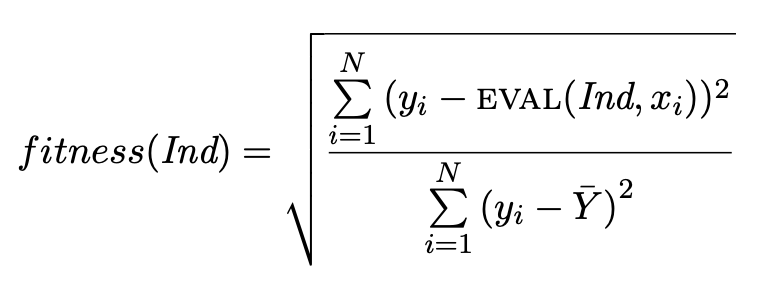

Calculamos a fitness dos nossos indivíduos usando a fórmula acima. As quatro funções abaixo executam esse cálculo para a totalidade da nossa população. A primeira, consiste no cálculo do denominador. A função eval calcula o valor retornado pelo indíviduo na i-ésima instância de x (i-ésima linha) percorrendo a sua árvore. calc_indFitness define a fitness do indivíduo iterando sobre todas linhas da matriz dos dados e retornando o valor da fórmula acima. Por fim, calc_globalFitness paraleliza o cálculo da fitness da população chamando instâncias de calc_indFitness para cada indivíduo.

In [ ]:
def calc_yMean(data):
  Mean = 0
  for i in range(len(data)):
    Mean += float(data[i][len(data[0])-1])
  Mean/=len(data)
  yMean = 0
  for i in range(len(data)):
    yMean += (float(data[i][len(data[0])-1])-Mean)**2
  return yMean

In [ ]:
def eval(solution, functionDim, x_values):
  if(solution.data == "sin"):
    return math.sin(eval(solution.right, functionDim, x_values))
  elif(solution.data == "cos"):
    return math.cos(eval(solution.right, functionDim, x_values))
  elif(solution.data == "+"):
    return eval(solution.right, functionDim, x_values)+eval(solution.left,functionDim, x_values)
  elif(solution.data == "-"):
    return eval(solution.right, functionDim, x_values)-eval(solution.left,functionDim, x_values)
  elif(solution.data == "*"):
    return eval(solution.right, functionDim, x_values)*eval(solution.left,functionDim, x_values)
  elif(solution.data == "/"):
    denum = eval(solution.left,functionDim, x_values)
    if(abs(denum)<0.01):
      denum = 1
    return eval(solution.right, functionDim, x_values)/denum
  elif(solution.data < 1):
    return solution.data
  else:
    return float(x_values[solution.data-1])

In [ ]:
def calc_indFitness(solution, data, yMean):
  functionDim = len(data[0])-1
  fit = sum([(float(x[functionDim]) - eval(solution.tree, functionDim, x))**2 for x in data])
  return (fit/yMean)**(1/2)

In [ ]:
def calc_globalFitness(population, data, yMean):

  pool = mp.Pool(mp.cpu_count())
  globalFitness = pool.starmap(calc_indFitness, [(solution, data, yMean) for solution in population])
  pool.close()

  for i in range(len(population)):
    population[i].fitness = globalFitness[i]

## 2.5 - Crossover

O crossover se faz por meio da troca de nós aleatórios entre os pais. Quando isso é feito se faz necessário recalcular a altura e a quantidade de filhos de cada nó. Garante-se que pelo menos um dos filhos sempre satisfaça a condição de altura exigindo que o nó escolhido para o segundo filho tenha uma profundidade máxima igual a altura máxima de uma árvore menos a altura da subárvore do primeiro filho a ser inserida. Existe porém uma grande dificuldade de se garantir a compatibilidade do nó do segundo filho na árvore do primeiro. Assim, devido ao alto custo computacional de garantirmos nós compatíveis para ambos filhos, preferiu-se aqui preservar o pai no caso da produção de um filho inválido.

Registra-se aqui se o crossover foi um sucesso ou falhou, ou seja, se o filho gerado é melhor que a média dos pais e também se houve geração de um filho inválido.

Se o parametro elitismo for verdadeiro, introduz-se os filhos à população somente se eles forem melhores que cada um dos pais. Caso contrário, preservamos o melhor pai no caso de um filho ótimo ou ambos no caso dos dois filhos serem piores.

In [ ]:
def crossover(parent1, parent2, population, solutionSize, data, yMean, elitism, functionDim):
  child1 = solution(Node(0))
  copyTree(child1.tree,parent1.tree)
  child2 = solution(Node(0))
  copyTree(child2.tree,parent2.tree)

  nodeToMutate_1, maxHeight = randomNode(child1.tree, solutionSize)
  nodeToMutate_2, maxHeight = randomNode(child2.tree, solutionSize - nodeToMutate_1.height + 1)

  aux = Node(0)
  copyTree(aux,nodeToMutate_1)
  copyTree(nodeToMutate_1, nodeToMutate_2)
  copyTree(nodeToMutate_2, aux)

  recalcHeightAndChildren(child1.tree)
  recalcHeightAndChildren(child2.tree)

  if(child2.tree.height > solutionSize):
    print("Crossover ERROR")

  invalidChild = 0

  if(child1.tree.height > solutionSize):
    child1 = parent1
    invalidChild = 1
  else:
   child1.fitness = calc_indFitness(child1, data, yMean)

  child2.fitness = calc_indFitness(child2, data, yMean)
  parentMean = (child1.fitness+child2.fitness)/2

  success = 0
  failure = 0

  if(child1.fitness<parentMean):
    success += 1
  else:
    failure += 1
  if(child2.fitness<parentMean):
    success += 1
  else:
    failure += 1

  if(elitism):
    if((child1.fitness > parent1.fitness or child1.fitness > parent2.fitness) and (child2.fitness > parent1.fitness or child2.fitness > parent2.fitness)):
      child1 = parent1
      child2 = parent2

    elif(child1.fitness > parent1.fitness or child1.fitness > parent2.fitness):
      if(parent1.fitness < parent2.fitness):
        child1 = parent1
      else:
        child1 = parent2

    elif(child2.fitness > parent1.fitness or child2.fitness > parent2.fitness):
        if(parent1.fitness < parent2.fitness):
          child2 = parent1
        else:
          child1 = parent2

  population.append(child1)
  population.append(child2)

  return success, failure, invalidChild

## 2.6 - Mutação

A mutação escolhida foi por meio de expansão. Escolhemos um nó aleatório da árvore e o trocamos sua subárvore por uma outra gerada a partir do método "grow" respoeitando o limite de altura das árvores. Aqui também se faz necessário recalcular a altura e a quantidade de filhos de cada nó. Se o parametro elitismo for verdadeiro e a solução mutada for pior que a original, adicionamos a original no lugar da mutada.

In [ ]:
def mutate(originalSolution, population, solutionSize, data, yMean, elitism, functionDim):
  mutatedSolution = solution(Node(0))
  copyTree(mutatedSolution.tree, originalSolution.tree)

  nodeToMutate, maxHeight = randomNode(mutatedSolution.tree, solutionSize)
  nodeToMutate = grow(maxHeight,functionDim)
  recalcHeightAndChildren(mutatedSolution.tree)
  if(mutatedSolution.tree.height>solutionSize):
    print("Mutation ERROR")

  mutatedSolution.fitness = calc_indFitness(mutatedSolution, data, yMean)

  if(elitism and mutatedSolution.fitness > originalSolution.fitness):
    population.append(originalSolution)
  else:
    population.append(mutatedSolution)

## 2.7 - Seleção

O núcleo do nosso algoritmo se encontra nessa seção. Escolheu-se utilizar o método geracional aliado ao uso de torneios para a seleção da população. Dessa forma, geramos uma nova população iterando sobre um loop que, de acordo com as probabilidades dos operadores genéticos passadas como parâmetros, escolhe um de três métodos de adicionar indivíduos.

A primeira possibilidade consiste em escolher o método crossover que irá gerar dois indivíduos. O segundo é a mutação que irá adicionar um indivíduo apenas. Por fim, com a probabilidade complementar a dos demais métodos, produzimos um indivíduo aleatório. A escolha de qual indivíduo será selecionado para execução dos dois primeiros métodos se basea no torneio de tamanho parametrizável.

Se houver elitismo na população, adicionamos ao fim desse processo os indivíduos reservados caso ainda não estejam presentes.

In [ ]:
def tournament(population, tournamentSize):
  competitors = rd.choices(population, k=tournamentSize)
  return min(competitors, key=lambda solution: solution.fitness)

In [ ]:
def reducePopulation(population, tournamentSize, populationSize):
  while(len(population)>populationSize):
   population.remove(max(population, key=lambda solution: solution.fitness))

In [ ]:
def selectNewPopulation(population, tournamentSize, populationSize, elite, eliteSize, solutionSize, data, yMean, operatorElitism, functionDim, mutationRate, crossoverRate):
  crossoverSuccesses = 0
  crossoverFailures = 0
  invalidChildProd = 0
  newPopulation = []

  while len(newPopulation) < populationSize - eliteSize:
    chance = rd.random()
    if(chance<crossoverRate):
      parent1 = tournament(population, tournamentSize)
      parent2 = tournament(population, tournamentSize)
      success, failure, invalidChild = crossover(parent1, parent2, newPopulation, solutionSize, data, yMean, operatorElitism, functionDim)
      crossoverSuccesses+=success
      crossoverFailures+=failure
      invalidChildProd+=invalidChild
    elif(chance-crossoverRate<mutationRate):
      winner = tournament(population, tournamentSize)
      mutate(winner, newPopulation, solutionSize, data, yMean, operatorElitism, functionDim)
    else:
      newRandom = newSolution(solutionSize,functionDim)
      newRandom.fitness = calc_indFitness(newRandom, data, yMean)
      newPopulation.append(newRandom)

  #Reintroduzimos as melhores soluções que possam ter sido perdidas no processo de evolução
  newPopulation.extend([solution for solution in elite if solution not in newPopulation])

  reducePopulation(newPopulation, tournamentSize, populationSize)

  return newPopulation, crossoverSuccesses, crossoverFailures, invalidChildProd

## 2.8 - Algoritmo

  O algoritmo em si é implementado por meio de um loop que chama a função que seleciona a nova população e armazena as estatísticas de cada geração.

  Guarda-se a evolução da pior, média e melhor solução, quantos crossovers deram certo, errado ou geraram filhos inválidos, o tamanho médio dos indivíduos e, por fim, o desvio padrão da fitness da população para termos certa noção da diversidade de nossa população. Para o dsevio padrão, desconta-se os 20% da população com pior fitness afim de evitar que indivíduos muito ruins e não representativos atrapalhem na visualização dos dados.

  O parâmetro operatorElitism define se os operadores serão executados de forma elitista ou não. Por fim, elitePorcentage define a porcentagem da população que será  "elitizada", ou seja, que impedimos de ser perdida nos processos de crossover e mutação. Por ser um método geracional, a liberdade de selecionar a porcentagem da população que será reproduzida se prova especialmente útil.

In [ ]:
def runAlg(populationSize, solutionSize, generations, mutationRate, crossoverRate, tournamentSize, operatorElitism, elitePorcentage, fileName):
  data = readFile(fileName)

  yMean = calc_yMean(data)
  functionDim = len(data[0])-1

  population = initPopulation(populationSize, solutionSize, functionDim)
  calc_globalFitness(population, data, yMean)

  eliteSize = int(populationSize*elitePorcentage)
  elite = []

  bestSolution = []
  worstSolution = []

  meanSolutionFit = []
  diversity = []
  meanSize = []

  population.sort()

  bestSolution.append(population[0])
  worstSolution.append(population[-1])

  meanSolutionFit.append(sum([solution.fitness for solution in population])/len(population))

  diversity.append(stdDev([solution.fitness for solution in population[:int(0.8*len(population))]]))

  meanSize.append(sum([solution.tree.children + 1 for solution in population])/len(population))

  crossoverSuccess = []
  crossoverFailure = []
  invalidChildEvo = []

  for i in range(generations-1):

    elite.extend(population[:eliteSize])

    population, success, failure, invalidChildProd = selectNewPopulation(population, tournamentSize, populationSize, elite, eliteSize, solutionSize, data, yMean, operatorElitism, functionDim, mutationRate, crossoverRate)

    crossoverSuccess.append(success)
    crossoverFailure.append(failure)
    invalidChildEvo.append(invalidChildProd)

    population.sort()

    bestSolution.append(population[0])
    worstSolution.append(population[-1])

    meanSolutionFit.append(sum([solution.fitness for solution in population])/len(population))

    diversity.append(stdDev([solution.fitness for solution in population[:int(0.8*len(population))]]))

    meanSize.append(sum([solution.tree.children + 1 for solution in population])/len(population))

  return bestSolution, meanSolutionFit, worstSolution, min(population), crossoverSuccess, crossoverFailure, invalidChildEvo, diversity, meanSize

## 2.9 Treino e teste

Aqui definimos a função que chamaremos de fato para nossos testes. Passamos os mesmos paramêtros que passaremos para runAlg com duas adições. A primeira delas será a quantidade de treinos que faremos, ou seja, quantas instâncias do algoritmo vamos chamar. A partir dessas instâncias, calculamos a evolução média das soluções assim como as melhores soluções de cada treino. Assim testamos esse conjunto de soluções ótimas na base teste cujo nome do arquivo será nosso segundo parametro adicional. Por fim, plotamos os graficos das estatísticas relevantes do nosso problema.

In [ ]:
def test(bestSolutions, testFile):
 data = readFile(testFile)
 yMean = calc_yMean(data)
 functionDim = len(data[0])-1
 calc_globalFitness(bestSolutions, data, yMean)

In [ ]:
def plotResults(bestEvolution, meanEvolution, worstEvolution, crossoverSuccess, crossoverFailure, invalidChildEvo, diversity, fitnessInTest, meanSize):
 plt.rcParams['figure.figsize'] = [20, 10]

 fig, ax = plt.subplots(nrows=3, ncols=2)

 ax[0][0].set_title("Mean Fitness Evolution")
 ax[0][0].plot(bestEvolution, 'g')
 ax[0][0].plot(worstEvolution, 'r')
 ax[0][0].plot(meanEvolution, 'b')
 ax[0][0].set_ylim([0,1.5])

 ax[0][1].set_title("Mean Fitness Evolution (log scale)")
 ax[0][1].plot(bestEvolution[1:], 'g')
 ax[0][1].plot(worstEvolution[1:], 'r')
 ax[0][1].plot(meanEvolution[1:], 'b')
 ax[0][1].set_yscale("log")

 ax[1][0].set_title("Fitness Standard Deviation")
 ax[1][0].plot(diversity)
 ax[1][0].set_ylim([0,min(1.5,max(diversity)+0.1)])

 ax[1][1].set_title("Mean Solution Size")
 ax[1][1].plot(meanSize)

 ax[2][0].set_title("Best Solutions Performance in Test Database")
 ax[2][0].plot(fitnessInTest, "-p")
 ax[2][0].set_ylim([0,min(1,max(fitnessInTest)+0.1)])


 ax[2][1].set_title("Crossover Successes, Failures and Invalid Child Production")
 ax[2][1].plot(crossoverSuccess, 'g')
 ax[2][1].plot(crossoverFailure, 'r')
 ax[2][1].plot(invalidChildEvo, 'y')

 plt.subplots_adjust(wspace =0.1, hspace=0.3)
 plt.show

In [ ]:
def trainAndTest(numTests, populationSize, solutionSize, generations, mutationRate, crossoverRate, tournamentSize,
                 operatorElitism, elitePorcentage, trainFile, testFile):
 mean_bestSolutionFit = []
 mean_meanSolutionFit = []
 mean_worstSolutionFit = []
 bestSolutions = []
 mean_crossoverSuccess = []
 mean_crossoverFailure = []
 mean_invalidChildEvo = []
 mean_diversity = []
 mean_meanSize = []

 mean_bestSolutionFit, mean_meanSolutionFit, mean_worstSolutionFit, best, mean_crossoverSuccess, mean_crossoverFailure, mean_invalidChildEvo, mean_diversity, mean_meanSize = runAlg(populationSize,
  solutionSize, generations, mutationRate, crossoverRate, tournamentSize, operatorElitism, elitePorcentage, trainFile)
 bestSolutions.append(best)

 for i in range(numTests-1):
   bestSolutionFit, meanSolutionFit, worstSolutionFit, best, crossoverSuccess, crossoverFailure, invalidChildEvo, diversity, meanSize = runAlg(populationSize, solutionSize, generations, mutationRate, crossoverRate, tournamentSize, operatorElitism, elitePorcentage, trainFile)

   if(i<1):
    mean_bestSolutionFit = [x + y for x, y in zip(mean_bestSolutionFit, bestSolutionFit)]
    mean_worstSolutionFit = [x + y for x, y in zip(mean_worstSolutionFit, worstSolutionFit)]
   else:
    mean_bestSolutionFit = [x + y.fitness for x, y in zip(mean_bestSolutionFit, bestSolutionFit)]
    mean_worstSolutionFit = [x + y.fitness for x, y in zip(mean_worstSolutionFit, worstSolutionFit)]

   mean_meanSolutionFit = [x + y for x, y in zip(mean_meanSolutionFit, meanSolutionFit)]
   mean_crossoverSuccess = [x + y for x, y in zip(mean_crossoverSuccess, crossoverSuccess)]
   mean_crossoverFailure = [x + y for x, y in zip(mean_crossoverFailure, crossoverFailure)]
   mean_invalidChildEvo = [x + y for x, y in zip(mean_invalidChildEvo, invalidChildEvo)]
   mean_diversity = [x + y for x, y in zip(mean_diversity, diversity)]
   mean_meanSize = [x + y for x, y in zip(mean_meanSize, meanSize)]
   bestSolutions.append(best)

 if(numTests!=1):
  mean_bestSolutionFit = [x/numTests for x in mean_bestSolutionFit]
  mean_meanSolutionFit = [x/numTests for x in mean_meanSolutionFit]
  mean_worstSolutionFit = [x/numTests for x in mean_worstSolutionFit]
  mean_crossoverSuccess = [x/numTests for x in mean_crossoverSuccess]
  mean_crossoverFailure = [x/numTests for x in mean_crossoverFailure]
  mean_invalidChildEvo = [x/numTests for x in mean_invalidChildEvo]
  mean_diversity = [x/numTests for x in mean_diversity]
  mean_meanSize = [x/numTests for x in mean_meanSize]


 test(bestSolutions, testFile)
 fitnessInTest = [solution.fitness for solution in bestSolutions]

 print("Desvio padrão para melhores soluções:" + str(stdDev(fitnessInTest)) + "\n")
 print("Média das melhores soluções:" + str(sum(fitnessInTest)/len(fitnessInTest)) + "\n")
 print("Melhor Solução encontrada para cada geração:")
 for solution in bestSolutions:
   print_tree(solution.tree)
 print("\nDados:\n")

 if(generations!=1):
  plotResults(mean_bestSolutionFit, mean_meanSolutionFit, mean_worstSolutionFit, mean_crossoverSuccess, mean_crossoverFailure, mean_invalidChildEvo, mean_diversity, fitnessInTest, mean_meanSize)
 else:
  plt.title("Best Solutions Performance in Test Database")
  plt.plot(fitnessInTest, "-p")

 bestSolutionFit.clear()
 meanSolutionFit.clear()
 worstSolutionFit.clear()
 crossoverSuccess.clear()
 crossoverFailure.clear()
 invalidChildEvo.clear()
 diversity.clear()
 meanSize.clear()

 mean_bestSolutionFit.clear()
 mean_meanSolutionFit.clear()
 mean_worstSolutionFit.clear()
 mean_crossoverSuccess.clear()
 mean_crossoverFailure.clear()
 mean_invalidChildEvo.clear()
 mean_diversity.clear()
 mean_meanSize.clear()



# **3 - Experimentos**

Fazemos aqui a otimização dos parâmetros na base de dados sintética 1 para depois observarmos a performance desses parâmetros nas demais bases de dados.
Os testes realizados estão também analisados na documentação.


Importamos primeiro os arquivos que serão utilizados

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving concrete-test.csv to concrete-test (1).csv
Saving concrete-train.csv to concrete-train (1).csv
Saving synth1-test.csv to synth1-test (2).csv
Saving synth1-train.csv to synth1-train (2).csv
Saving synth2-test.csv to synth2-test (1).csv
Saving synth2-train.csv to synth2-train (1).csv


## TESTES A

Inicialmente utilizamos parametros iniciais de crossover e mutação como 0.9 e 0.05 respectivamente, população igual a 500, 50 gerações e com elitismo de apenas um indivíduo.

Desvio padrão para melhores soluções:0.15096445035063216

Média das melhores soluções:0.2520506997979813

Melhor Solução encontrada para cada geração:
((cos(cos(X1))/((X1+cos(X1))-(X1/0.23012602831014095)))*(((X1*(0.38961062149084147+(0.11624105557028463/0.4438657425058061)))-(0.02444790929853391-(-0.3114836455864751*X1)))*cos((-0.3532441984591119+0.41987901671955163))))
(((X1+X1)-cos((X1+(-0.4075332582704114+X1))))+(cos((X1+X1))+(((X1+(-0.4075332582704114+X1))+X1)*(-0.4075332582704114+(X1+(-0.4075332582704114+X1))))))
(((X1*(X1*(X1*(-0.9560869508229801+X1))))+0.962153787908081)+(0.30924310729102666-0.4699814920773646))
((((0.983763703507663*(X1-(X1*X1)))+((X1/sin(0.8037116460110234))/X1))+(X1*X1))+(((X1*((0.34809533066622467+X2)/(X1*X2)))+(X1*X1))+((0.983763703507663*(X1-X2))+(-0.43864617257735583/X1))))
(((X1*X1)+((-0.1967485327215821-sin(sin(X1)))*sin(-0.6164743650851043)))*(X1*(sin(-0.2858506218075727)-(0.8159530100341814-(0.29430509988976894-X1)))))
((((((-0.24783500171045403*X1)-

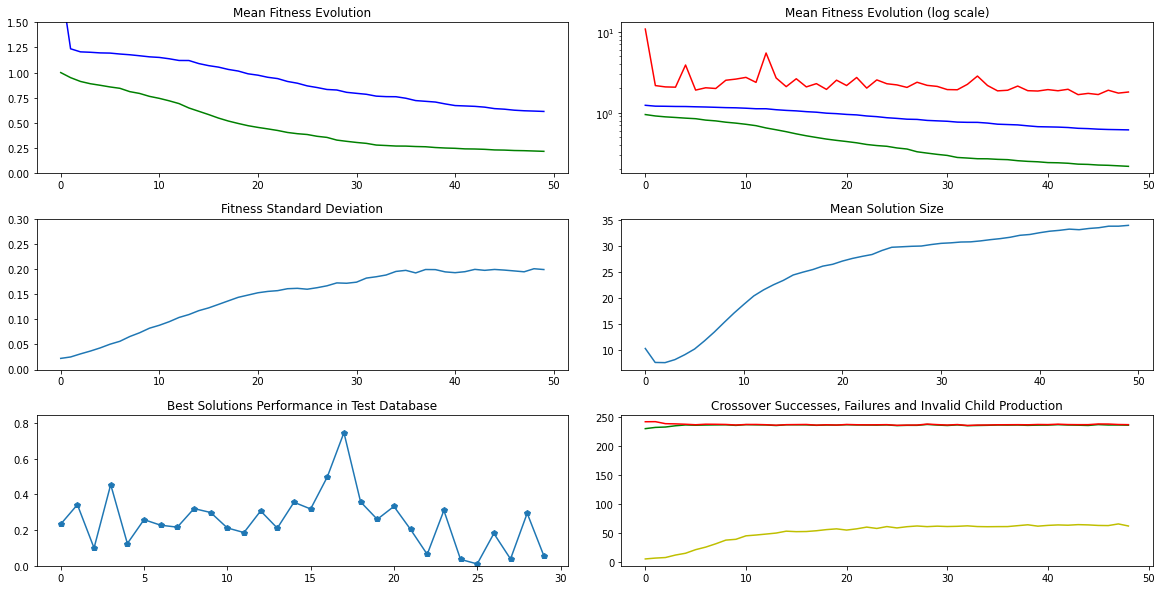

In [ ]:
trainAndTest(30, 500, 7, 50, 0.05, 0.9, 2, False, 1/500, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.2396860743780578

Média das melhores soluções:0.4347841584052471

Melhor Solução encontrada para cada geração:
((((sin((X1/0.2940723823506164))/X1)-X1)-((((X2-X1)*X1)+(-0.605388481469354*X1))+(-0.21543103014635934*sin((X1/X1)))))+(((sin(X1)/X1)-X1)-(((sin(X1)/X1)-X1)-((X1/(0.8870237514422052+0.6119500225899062))/(-0.21543103014635934*sin(X1))))))
(sin(0.7298814742755397)/((-0.742471177942498-(X1*(X1+(X1+-0.8547491889577268))))+((-0.6191469066113029/(X1--0.742471177942498))-(X1*(X1+(X1+-0.742471177942498))))))
((((((X1*X1)*cos(X1))+(cos(X1)-X1))-(X1*X1))+((X1+((X1*X1)*cos(X1)))-((X1*X1)+((0.864625369025493*X1)-cos(-0.5490984532835201)))))+(((X1*X1)*cos(X1))-((X1+((X1*X1)-X1))-(((X1*X1)*cos(X1))-sin((X1*X1))))))
(((X1-((cos(X1)-X1)+(X1*X1)))+(X1-((X1-(X1*X1))+(X1-(X1*X1)))))+((X1-(X1*X1))+(X1-((cos(X1)-(X1*X1))+(X1*X1)))))
(X2+(sin(cos(0.6181233762029521))*(((X1+X1)+X1)*(X1+(X1+cos(X1))))))
(-0.5294866402374963-(-0.5294866402374963-((X2+(-0.12546841

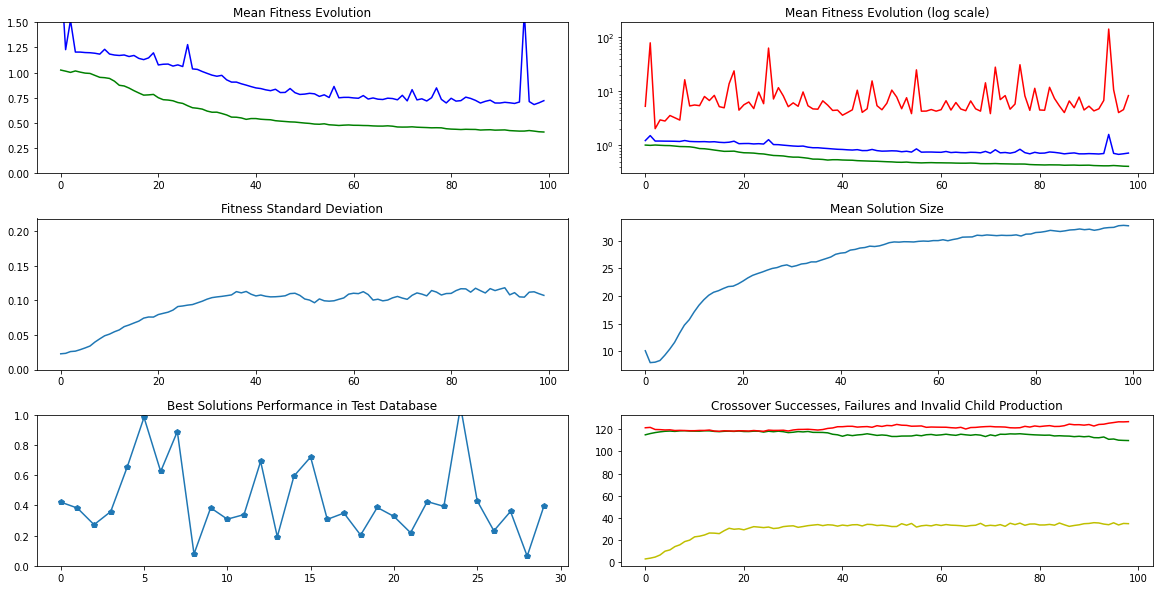

In [ ]:
trainAndTest(30, 250, 7, 100, 0.05, 0.9, 2, False, 1/500, "synth1-train.csv", "synth1-test.csv")

## TESTES B

Desvio padrão para melhores soluções:0.16580825417413161

Média das melhores soluções:0.3009587944606821

Melhor Solução encontrada para cada geração:
(X2+((-0.14780871716444688/((0.2475444830151321+X1)-(X1*X1)))-(-0.7047496135415223/(X1-((0.41079140817648296+X2)+(-0.28117501855603866*-0.7562238936919368))))))
((X1/0.2233880827804795)/(X1+cos((X1+cos((X1-0.23764188411917941))))))
((X1*X1)*(0.2619354234508302+(X1-(X1*X1))))
((sin(X1)-(X1+(sin(X1)-(sin(X1)-(X1+X1)))))*((-0.3707163170123906--0.04651720721546537)/(-0.7980976786843033+X1)))
((X1+((0.6692678132014893-(cos(0.9653304964366178)*(X1--0.5705283596932655)))/(0.8263970675686867*(X1+X1))))-(cos(sin(X1))*((cos(sin(X1))/(-0.4141923605266802/X1))+(((-0.4141923605266802/X1)*(-0.4141923605266802/X1))+(cos(0.5807328775583527)*cos(-0.5705283596932655))))))
((((X1*(0.7857905094006481/(0.7857905094006481/X1)))-(0.7857905094006481/(0.7857905094006481/(0.7857905094006481/X1))))-(X1*(sin(X1)-(0.7857905094006481/(0.7857905094006481/X1)))))+(((X1

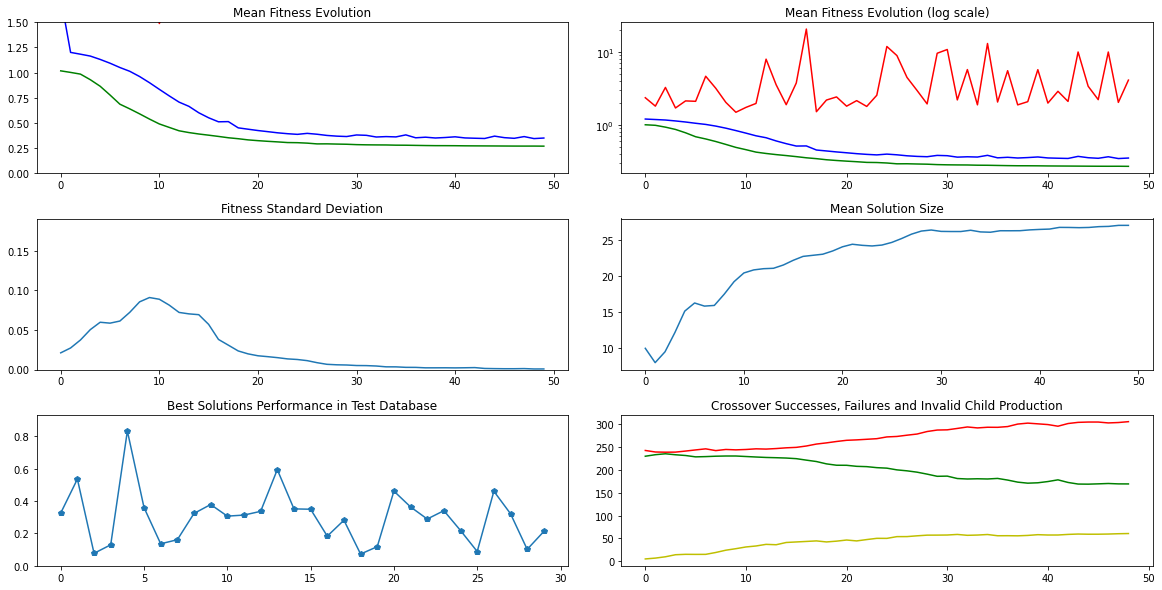

In [ ]:
trainAndTest(30, 500, 7, 50, 0.05, 0.9, 2, True, 0, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.13808118875151495

Média das melhores soluções:0.2325524762973039

Melhor Solução encontrada para cada geração:
((cos(cos(X1))+((-0.9879374806965027*X1)+(X1*X1)))+(X1*((0.8883385681098053-(X1*X1))*(-0.870549824526023+X1))))
((((X1+X1)-(X1-(0.7770273849579152+X1)))*(X1-(X1-cos((0.8266801620190702-0.9147710744029391)))))+((0.8420591959420487-(X1+((X1-0.9284207837718801)-X1)))*(0.8046457680157664-((X1-sin(X1))-sin(0.9147710744029391)))))
((0.6137996975809619*(X1/cos(cos(X1))))/((X1+(-0.4125594122209235/0.8156934228235164))+(X1+(0.7350130365106435-((X1+X1)*sin(0.3856393936759963))))))
((cos((X2/X1))-X2)-((X1*X1)*(X1-((X1*X1)+(-0.4219835511082841+cos(-0.9346598440103304))))))
(cos((((-0.9611824375044205*-0.5410538865040262)*(0.17829058745321902*(X1+-0.28529916825867097)))*(sin(X2)*(X1+0.01465470423345816))))/((cos(cos(X1))+(0.48386087888625706*sin(X1)))/(sin(0.2766997464096512)/(((0.12750893734539526*-0.5830412369484701)+0.38276135843688674)+((X1+0.835

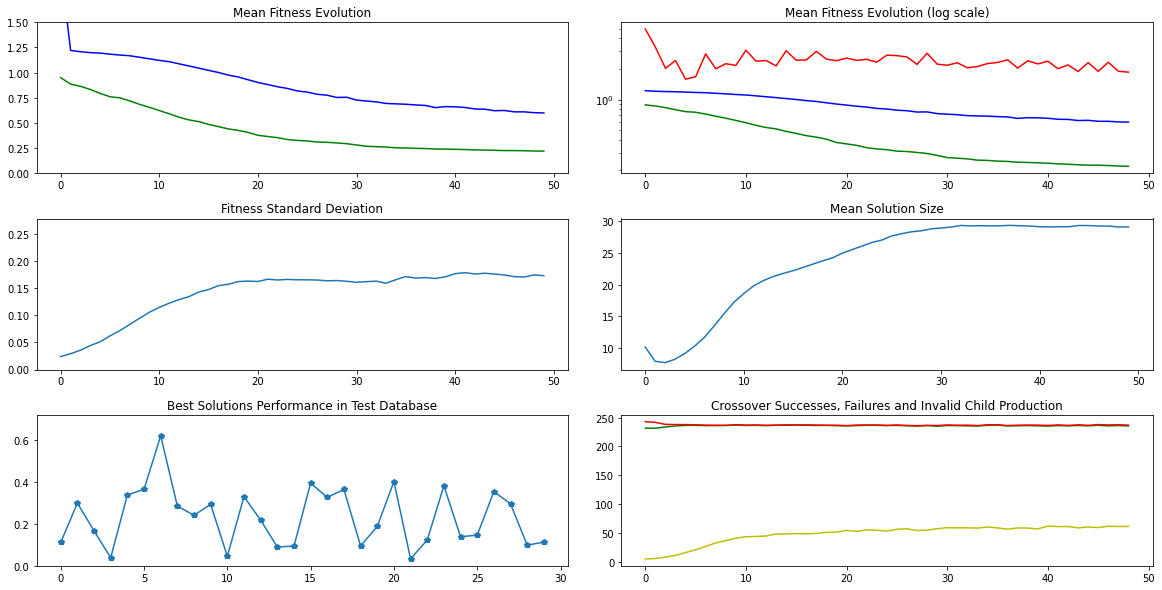

In [ ]:
trainAndTest(30, 500, 7, 50, 0.1, 0.9, 2, False, 1/500, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.1740441351047114

Média das melhores soluções:0.20970174815508502

Melhor Solução encontrada para cada geração:
((((-0.528099056058996/(cos(0.636170725539084)+(-0.6691383770110286/0.0953402484205399)))*(-0.6691383770110286/X1))-(cos(cos(X1))/((cos(0.636170725539084)+(-0.6691383770110286/0.0953402484205399))/(cos(X1)-(X1*X1)))))+(((-0.528099056058996/(sin(X1)-X1))*X1)-((cos(cos(X1))/(X1-(X1*X1)))+(0.6352924829867552+(X1-(X1*X1))))))
(((((0.1287711737411068-(X1*X1))*((-0.706033637888027*X1)+(X1*X1)))-(cos(X2)+((X2-X2)/X1)))+((cos(sin(0.8079489569645739))-(sin(X1)*cos(-0.6684856196556492)))-(cos((X2-X2))-(X2+(0.9323598203443588-X1)))))-((-0.6684856196556492*(-0.9066421209611273+0.22287839174752078))+(sin(X1)*cos(-0.7083575780996374))))
((X1-(0.9147983655110257+(X1-(0.9147983655110257+(X1-0.9036839789638833)))))*(X1-(X1-(-0.7151373808330057/sin((-0.7151373808330057/X1))))))
((X1+X1)-(0.3105995430448858/(sin(0.5840415592414714)-(X1*(X1+(X1+-0.946403013

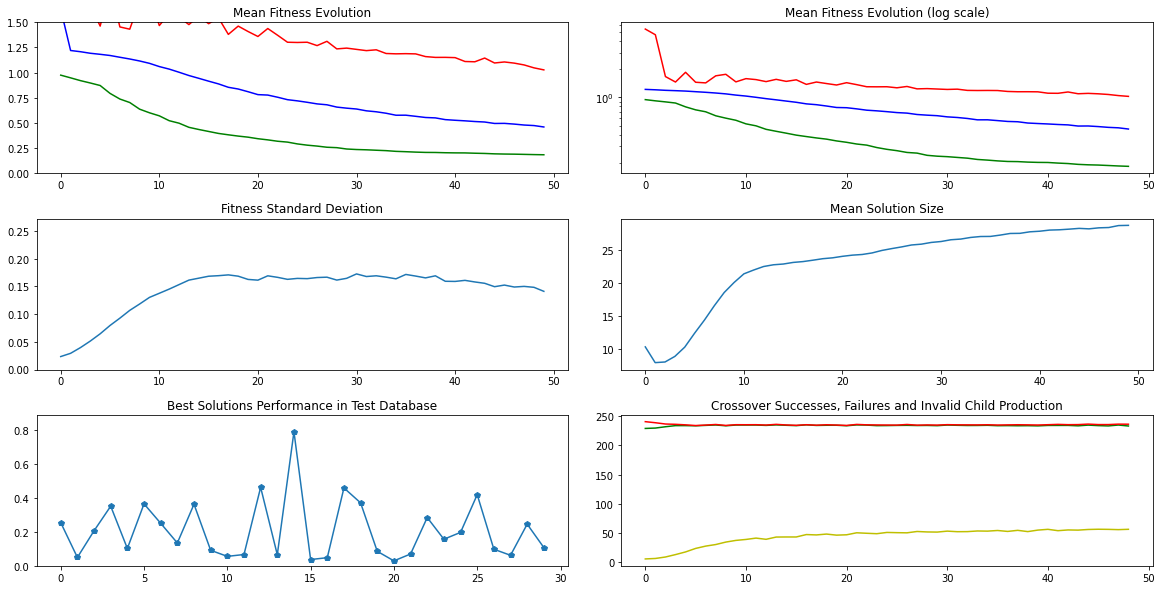

In [ ]:
trainAndTest(30, 500, 7, 50, 0.1, 0.9, 2, False, 0.01, "synth1-train.csv", "synth1-test.csv")

## TESTES C

Desvio padrão para melhores soluções:0.3936758341194679

Média das melhores soluções:0.35689932610265

Melhor Solução encontrada para cada geração:
(((0.10708553226619544+(X1*X1))+(X1*X1))*((((0.860159406747244-sin(X1))-cos(sin(X1)))-((0.860159406747244-sin(X1))*cos(sin(X1))))-cos(sin(X1))))
(0.19004345926871902/(X1*(0.316461422088389-(X1+-0.5116965484312948))))
(((0.3266742672401022/X1)*((-0.24602547991750612-0.7876970660805296)*(0.667518657363644/(-0.3499524418401727+(-0.3499524418401727+X1)))))+(X1*(0.667518657363644/(-0.3499524418401727+(-0.3499524418401727+(-0.3499524418401727+X1))))))
(X2-(sin((-0.6512987848507581+-0.6512987848507581))/(((X1*X1)/(X1/0.8757076011696701))/((0.699054818980468-X1)-sin((X1/0.9421589473356997))))))
(sin((0.5634194291159542-(0.5634194291159542-(X1+(0.5634194291159542-X1)))))-((0.5634194291159542-(0.5634194291159542-(X1+(0.5634194291159542-X1))))*(X1+(X1+X1))))
((((-0.7661877564767217*cos((-0.4203621443147678-X1)))*X2)+((X1/(0.14307720576946625/(X1*X1)))

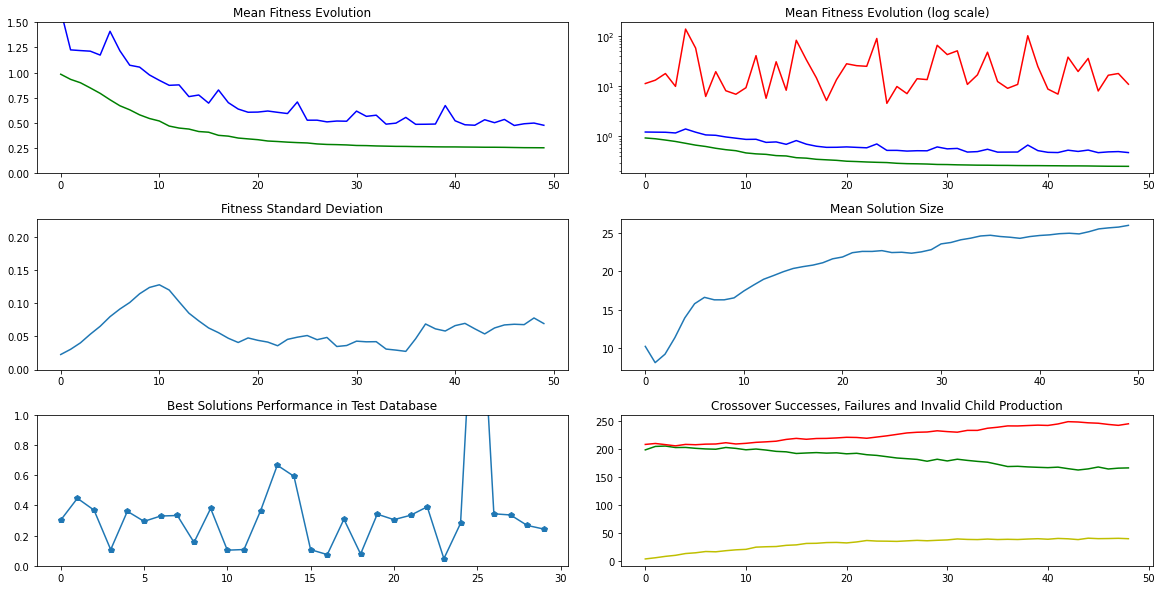

In [ ]:
trainAndTest(30, 500, 7, 50, 0.05, 0.7, 2, True, 0, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.10809395222423718

Média das melhores soluções:0.19856335674340003

Melhor Solução encontrada para cada geração:
((0.42735053588614114+(-0.8829861464868505-(X1-X1)))+(X1*(X1*(X1-(X1*X1)))))
(X1*((X1*(cos(0.19075735324161447)+(X1-(X1*X1))))+(0.45444190681405083/(0.5850016152938153*(0.5850016152938153*(-0.9784337774173124*X1))))))
(((X1*(cos(sin(X1))+0.976902204684571))+(0.7713578888135899/cos(((0.7713578888135899/X1)+(0.4720603135091843*0.6552896018788741)))))*(X1+((0.7713578888135899/X1)+((0.7713578888135899/X1)+sin(-0.9641123008870669)))))
(((X1*X1)*((0.029895407417604547+-0.5727142991936249)*(X1*X1)))-(((X1*X1)*(X1+((0.029895407417604547+-0.5727142991936249)*(X1*X1))))-(sin(cos(X2))-cos(cos((-0.2762801500452545/0.7505443490705397))))))
(((0.05962543135169396-X2)-X1)+((X1*(0.5636407972482707-X1))*(X1*(0.05962543135169396-(0.5636407972482707-X1)))))
((((X1*(X1-sin(-0.15523049876492423)))*(-0.7038089815327606-(X1-0.37635219071192294)))*X1)+(0.95646

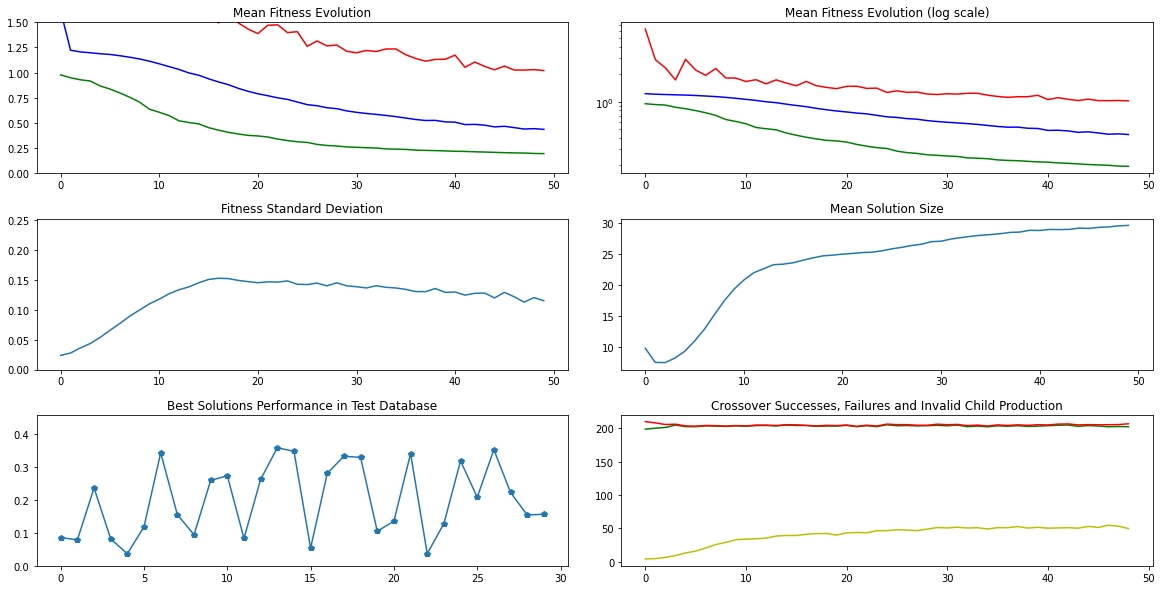

In [ ]:
trainAndTest(30, 500, 7, 50, 0.3, 0.7, 2, False, 0.01, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.1520891287432156

Média das melhores soluções:0.21106278127439096

Melhor Solução encontrada para cada geração:
(X2-(sin(cos(sin(X1)))+(((X1-(X1*X1))*(X1*X1))+sin(cos((X2/X1))))))
(((-0.1192916795423149-(X1-0.7500242705273759))*((X1*X1)*(sin(X1)-(X1+sin(X1)))))-cos(0.7500242705273759))
(((((-0.7772669779308421/(X1-0.9801557229537576))*(X1+X1))+(-0.7772669779308421/(X1-0.9801557229537576)))+((-0.7772669779308421/(X1-X2))*(X1+sin((X1-0.9801557229537576)))))+(-0.11037717879321929-(((-0.7772669779308421/(X1-0.9801557229537576))*(X1+X1))+(X1-(X1*0.9801557229537576)))))
(((X1-(-0.6353772091018051/cos(X1)))-X1)*((X1-(X1-(X1/X1)))-X1))
(X1*((X1+(X1+(cos(X1)+(-0.8702724990663169+X1))))+((X1/((-0.8702724990663169+0.0010842352280364675)+(-0.4300276785599204/X1)))+((-0.4300276785599204/X1)-(cos(X1)+(-0.8702724990663169+X1))))))
(((X1*X1)*X1)*(X1+(cos(cos(sin(-0.8326501069349097)))--0.3093163797052585)))
((X2*(0.6503537115233771+(0.8709955822137128*((X2-X2)-(-

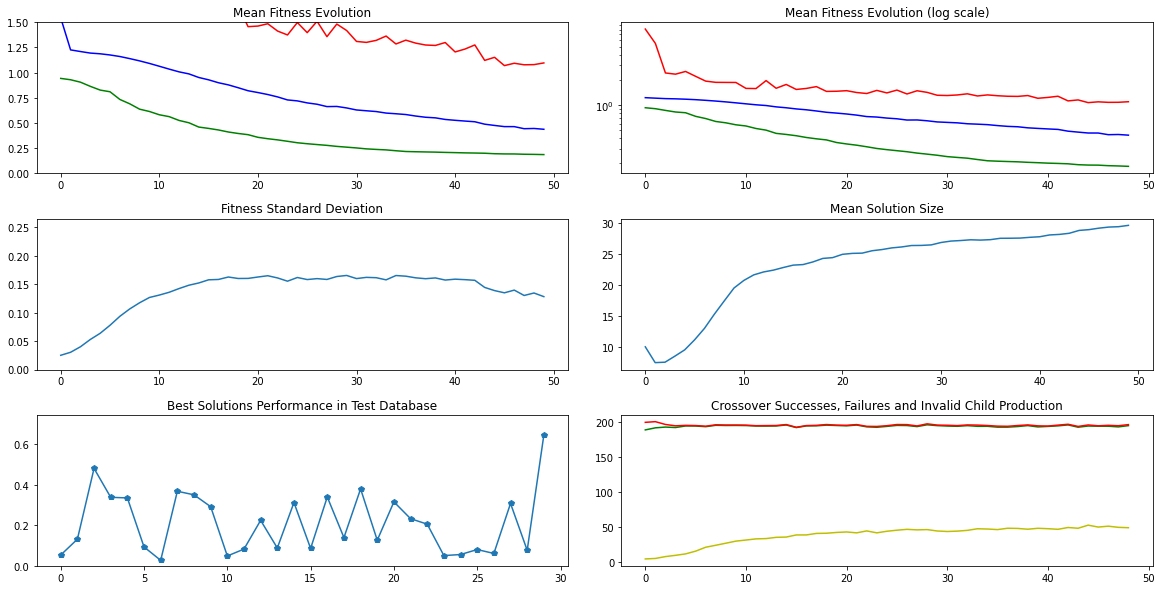

In [ ]:
trainAndTest(30, 500, 7, 50, 0.3, 0.65, 2, False, 0.01, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.14389790023245763

Média das melhores soluções:0.18758403661638376

Melhor Solução encontrada para cada geração:
((((sin(0.25785666031165233)/(X1*X1))-cos(((0.9784341675043529-X1)*(-0.649851208547157+0.8800120128380213))))-(((0.9784341675043529-X1)*sin(cos(X1)))-sin(sin(cos(X1)))))+(((X1*X1)-((X1+X2)-((X1+0.8800120128380213)-(X1*X1))))+((((-0.5701905285214304*X1)*(-0.01936524044464316+X1))+(X1+-0.7679486183021851))*((X1*X1)*sin(cos(X1))))))
(X1*((X1*(X1+((X1*X1)-(0.6444020452822348+0.14299254478006995))))-(-0.4697498800354061+(0.6444020452822348+X1))))
((cos(cos(X1))/((X1*(-0.6771400068042774+(0.7145408379135554/X1)))+(X1*(X1+(X1+X1)))))+(((X1+(X1+(0.7145408379135554/X1)))+(sin((0.7145408379135554/X1))*(-0.6771400068042774+(0.7145408379135554/X1))))-sin(cos(X1))))
(((X1*X1)*((((X1-0.9806957921963182)*X1)+0.9806957921963182)-0.9806957921963182))+(-0.9992613572155888-(X2-0.3213374573418073)))
(((X1+X1)-(cos((0.13011835961530527*(X1*X1)))/(X1*(X1+X1)

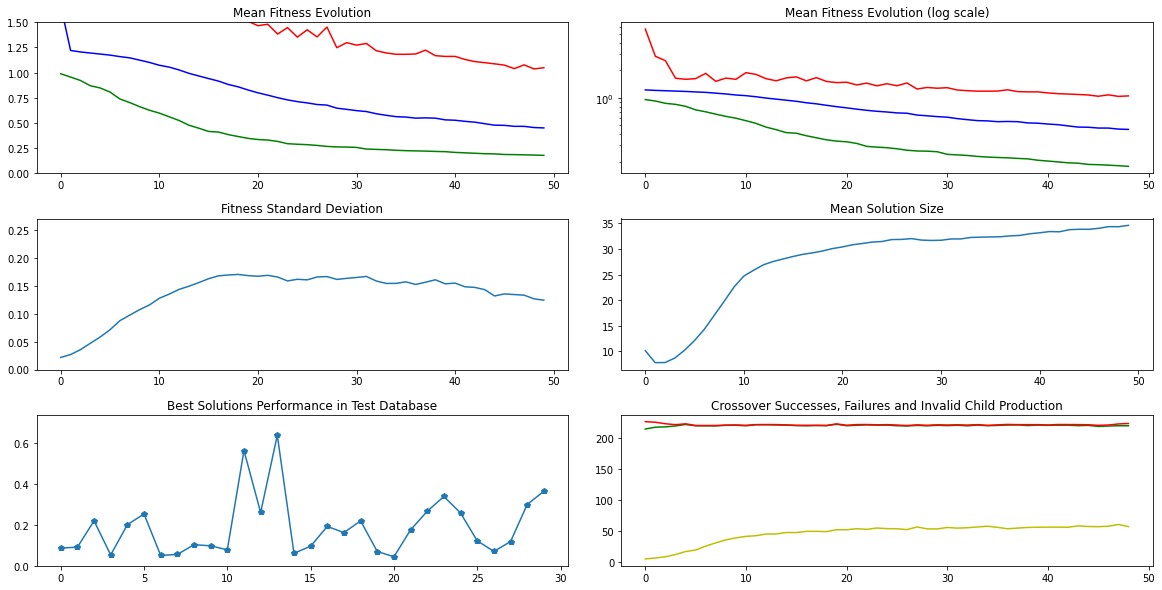

In [ ]:
trainAndTest(30, 500, 7, 50, 0.2, 0.8, 2, False, 0.01, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.12497731873243274

Média das melhores soluções:0.2297072085487975

Melhor Solução encontrada para cada geração:
(((X1-((X1*X1)+(sin(0.41490284765432617)/(X1*X1))))+(X1-(X1-((X1*X1)+(X1*X1)))))+((0.7379791427192626*-0.9534469598438109)+(X1-((cos(0.9763258471338814)*X1)-((X1*-0.5738156651921229)+(X1*X1))))))
(((sin(0.11918715221177378)/cos(cos(-0.5612580857714)))*cos((X1-0.5844913978450703)))+(((sin(0.11918715221177378)/(-0.752610130077898-(X1*X1)))*cos((X1-0.5844913978450703)))-((sin(0.11918715221177378)/(-0.752610130077898-sin(X1)))*cos(cos(X1)))))
(((cos(sin((-0.2841418102015705/0.8056697531932568)))-X1)*(X1*(X1*X1)))+(-0.2338480578051687+(cos(0.050568104929159086)*0.9856370683106885)))
(((X1+(((X1*X1)-(0.6815208647942552/X1))+sin((X2+0.17677917105631735))))-cos((X1-(0.1329189320755073-X1))))+(((0.411400037466481*(X1*X2))-(((X1*X2)*(-0.8183406960154855*X1))-(0.1329189320755073-0.538174365299849)))*((X2+0.17677917105631735)/(X1*X1))))
((-0.3768866

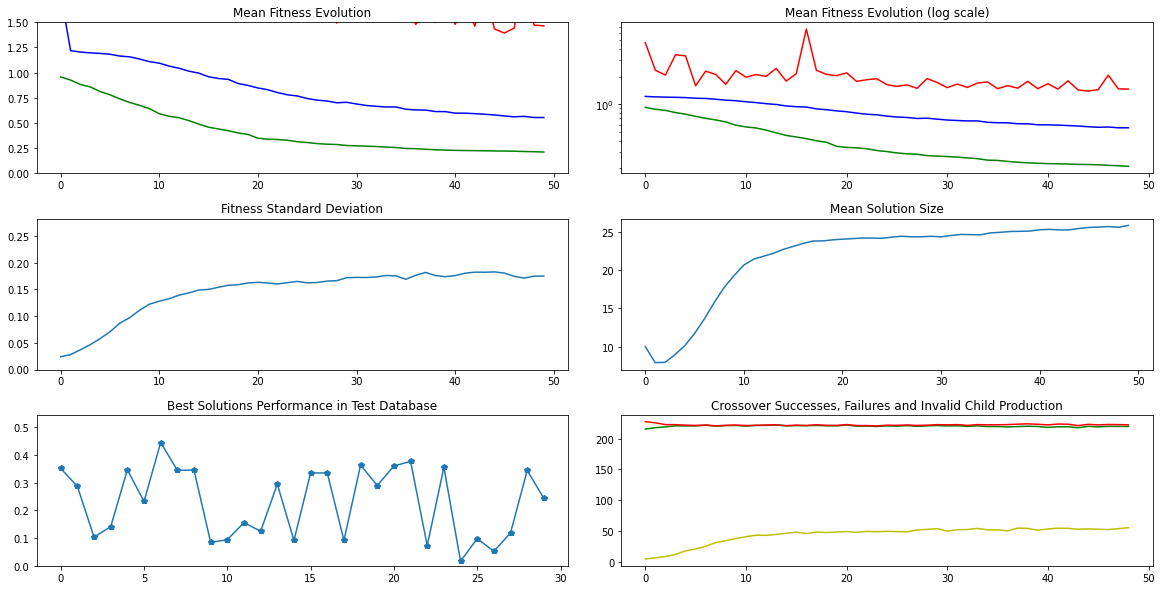

In [ ]:
trainAndTest(30, 500, 7, 50, 0.2, 0.8, 2, False, 3/500, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.11825138646075017

Média das melhores soluções:0.19397326728951172

Melhor Solução encontrada para cada geração:
(((X1*(X1+-0.22705963822050923))+(((-0.37970970170127405*X1)*(X1+X1))*(-0.7579410588337687-(X1*(X1-0.9064552558307539)))))+((cos((X1-X1))+(sin(X1)-(X1*(X1-0.6052002951154776))))+(((-0.37970970170127405*X1)*X1)*(sin(X1)-(X1*(X1-0.9064552558307539))))))
(-0.9936185946286804-((X1*X1)*(X1-(X1*X1))))
((X1*X1)+(0.1642160061184188/(((cos(-0.44966898328624105)+0.6930197212714775)-cos((X1*X1)))+((X1-cos(0.8982246294837017))+(X1*X1)))))
((X1-(X1+-0.928679119652617))-(X2-(X1*(X1*(X1-(X1*X1))))))
(cos((((X1+X1)+(0.8222507087539705+(0.5929965912749002/0.8222507087539705)))+cos(((0.5929965912749002/0.8222507087539705)+-0.6802540480488579))))-(cos((((X1+X1)+(-0.2762680207960897/-0.6802540480488579))+cos((-0.2762680207960897/X1))))-((-0.2762680207960897/X1)*(-0.6009272443822575/(X1+-0.8815241198385446)))))
(((X1-0.6738158243253525)*(X1+cos((X1+sin(0.99

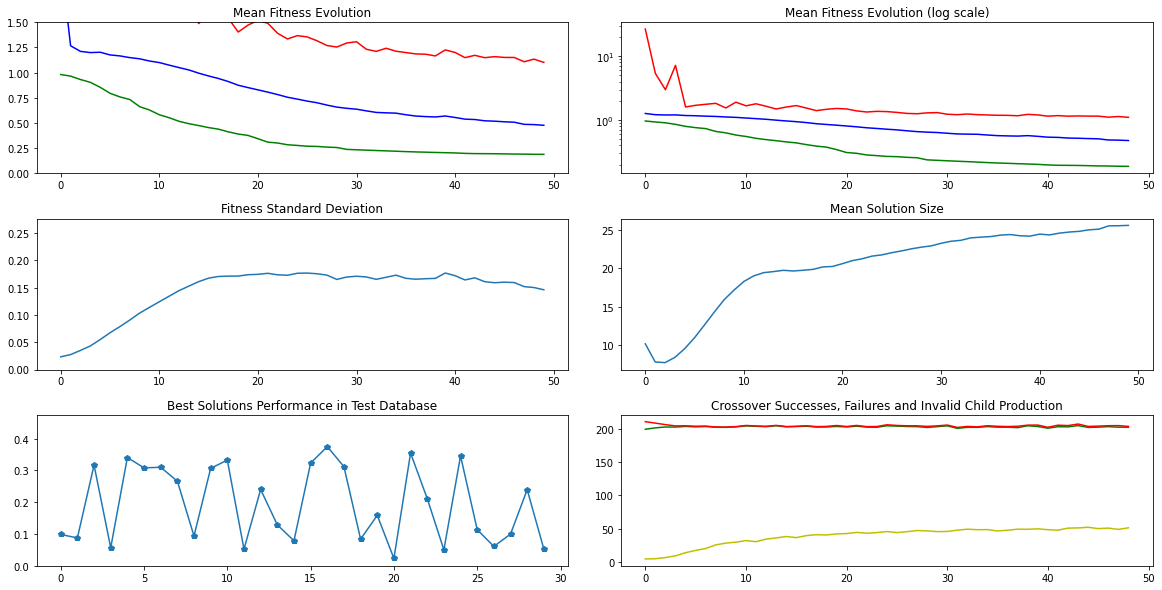

In [ ]:
trainAndTest(30, 500, 7, 50, 0.25, 0.7, 2, False, 0.01, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.10909622766192341

Média das melhores soluções:0.19970370208697133

Melhor Solução encontrada para cada geração:
(X1-(((X1*cos(X1))+(-0.7346283439993235+cos((X1*X1))))+((0.14504420202394086/((-0.3473571286311401+X1)*X1))+(-0.7940327126332389*(-0.9221593461508277-X1)))))
(((0.5624961951063354*(cos(0.590949068489889)*(X1+-0.8826739303687559)))*(X1+X1))*(X1*(X1+((X1+(-0.4527563647343069+0.4996164640559435))/0.4996164640559435))))
((((X1*X1)*X1)-((sin((0.20232055488293765/-0.2910685451270545))--0.4970149333155849)+(X2*-0.4970149333155849)))+((X1*X1)*((-0.5149479002513557--0.4970149333155849)-((-0.5149479002513557--0.3087006629678246)+((X1*X1)*(X2/X2))))))
((((X1+((X1+-0.1683108717141213)+X1))+((X1+X1)*(-0.8258440012116619*X1)))+((X1+X1)*(-0.8258440012116619*X1)))*(((-0.698439803212336-0.7811117296287213)+cos((X1+X1)))-sin((-0.09130920713550217*(-0.698439803212336-(-0.698439803212336-0.7811117296287213))))))
((X1+(((sin(-0.8020808371198476)-(X1-0.85520

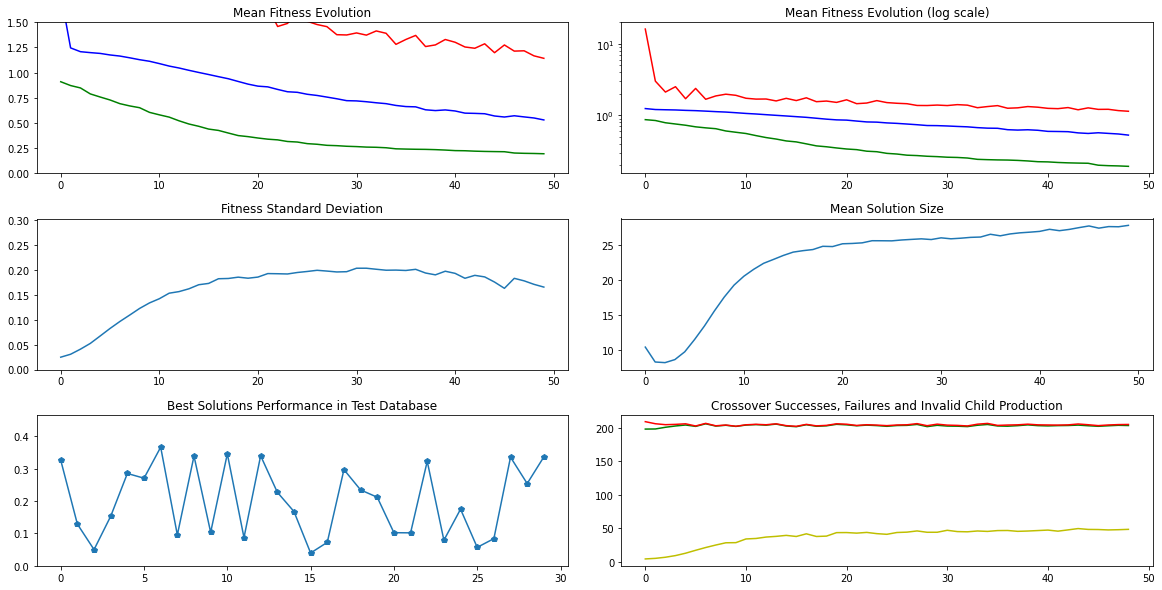

In [ ]:
trainAndTest(30, 500, 7, 50, 0.2, 0.7, 2, False, 0.01, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.10673613964290812

Média das melhores soluções:0.2048666986212132

Melhor Solução encontrada para cada geração:
((0.5775186349070154/((-0.734428599951584/0.9874071655635546)*(X1+X1)))+((sin((X1/0.2926363090887183))/(X1+X1))+((-0.734428599951584/0.9874071655635546)*(-0.734428599951584/(-0.734428599951584/0.9874071655635546)))))
(((((0.43009249394741134/X1)*(X2/X2))+((X1-X1)/X1))+cos((cos(0.6477736092680118)*X1)))*((sin(X1)-((X2/X2)*(X1+-0.4127204470960524)))+(0.8431258106211101-(X1+-0.0992146695509255))))
(((X1*(X1*X1))+(X2*sin(0.8735606923454102)))-((X1*(X1*(X1*X1)))+(X2*(X2*0.6445115626275857))))
((cos(0.4855912578136399)/((sin(X1)-cos(-0.009537231338773156))+((X2*0.4855912578136399)-(X1-(-0.3766651232946929*X2)))))+(X1*(X1*(X1*(X1+cos(X1))))))
(((((-0.45843929992404453-0.014525397829902698)-((X1*0.9299255158695277)+(X1/-0.12960217856446854)))+((0.5117430363984015/(X1*X1))+cos((X1-0.29996986666820713))))*((sin(cos(X1))-cos(cos(-0.2495784850517699

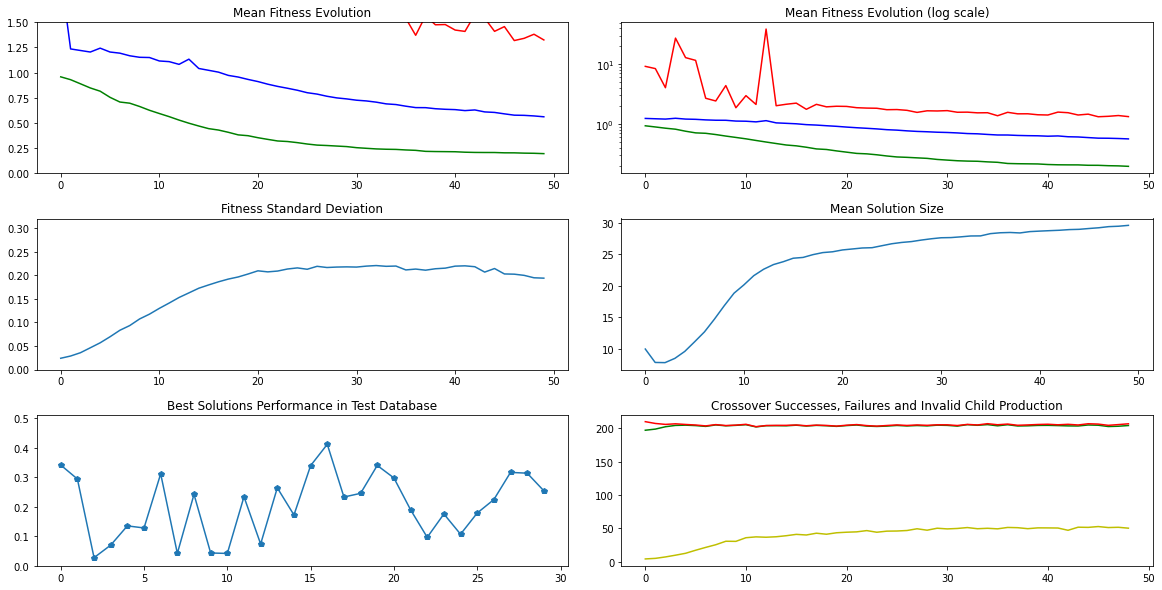

In [ ]:
trainAndTest(30, 500, 7, 50, 0.2, 0.7, 2, False, 3/500, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.15112888513247527

Média das melhores soluções:0.24664799760124737

Melhor Solução encontrada para cada geração:
(((X1-(X1*(-0.08782512967346134+0.9946476619247335)))+((sin(-0.442697841582516)/(-0.2559007151024082+(0.48717247198298663/X1)))+(sin(X1)/X1)))+(sin(-0.7490286686078858)+((X1*(0.48717247198298663/(0.48717247198298663/X1)))+(X1-((-0.24420320470322165+X2)-(X1*X1))))))
(((-0.975266136867087-(X1*(X1*(0.12300621451042093/0.3816661667218424))))+(((0.5997526201176901--0.43683492273751945)-(0.3316976369203921*0.8798490816573408))/((0.5606332373244545*X2)/(-0.255064730921583/X2))))+((((0.5997526201176901--0.43683492273751945)-(0.3316976369203921*X1))/((0.5606332373244545*X2)/(-0.255064730921583/X2)))-(-0.8159943792255004-(0.3316976369203921*X1))))
(((X1*(X1*(X1-(X1*X1))))-0.5698534623565463)-((0.5455402813452714-(-0.8561593467960813-cos(cos(X1))))+cos((0.5455402813452714-(-0.8561593467960813-(0.38915863956740093/X1))))))
(((X1*X1)*(X1-(X1*X1)))+(

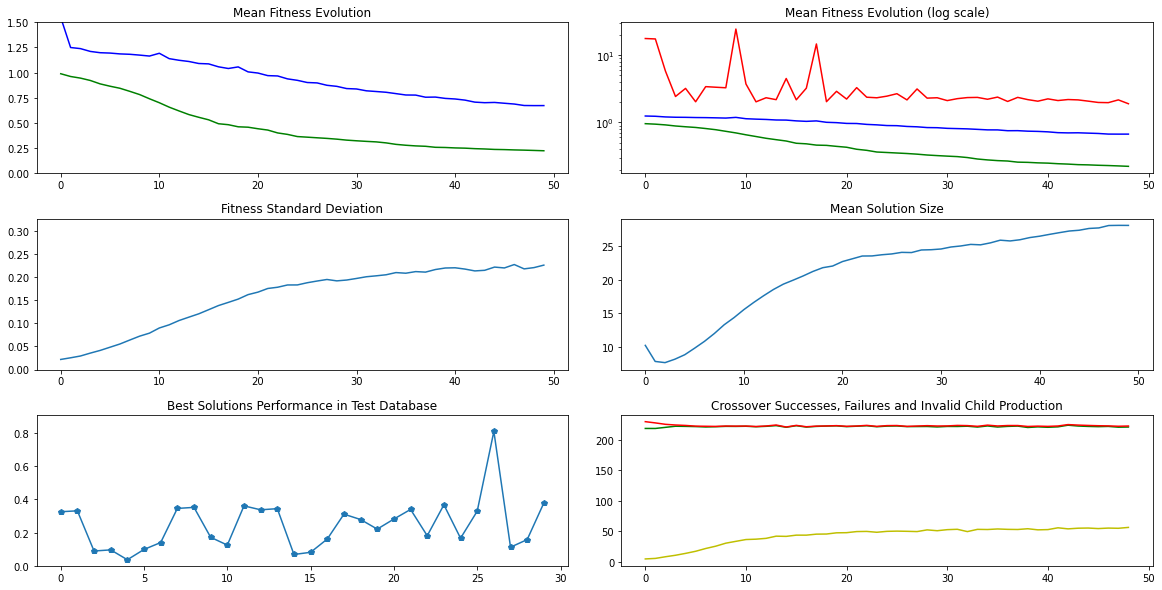

In [ ]:
trainAndTest(30, 500, 7, 50, 0.1, 0.8, 2, False, 1/500, "synth1-train.csv", "synth1-test.csv")

## TESTES D

Desvio padrão para melhores soluções:0.11748824102350112

Média das melhores soluções:0.2515956237676159

Melhor Solução encontrada para cada geração:
(((((0.7546818572634388*X1)*(0.3909475511496612+0.9447952828647543))+(sin(0.9660822775383331)*(-0.7803849629177717*cos(X1))))*cos((sin(-0.20255416404917082)/(X1/0.3557111395300401))))*((cos(-0.46858145187750444)/((X1*(0.3909475511496612+0.9447952828647543))-((X1*X1)-(X2/X2))))-(((X1*0.3557111395300401)-cos(X1))/((X1/X1)-(-0.19417422229891734/0.3557111395300401)))))
(cos((-0.3442112008059217*X1))/(cos(((X1-sin(-0.44186060216336953))+(X1+(X1+X1))))+(((X1+(X1+X1))+(X1+(-0.3442112008059217*X1)))-(cos(X2)-((X1+X1)*(X1+X1))))))
((((X1*-0.5086711445388274)+cos(sin((X1*-0.5086711445388274))))+(sin(0.5170702785986352)/(X1*cos(X1))))*(((-0.4134856214808895-sin(cos(-0.3977272920996271)))/sin(-0.3977272920996271))/((0.7023542022672771-X1)+(X2-X2))))
(((-0.4171946494923471/X1)-X1)-(X1-(X1-(0.15804832841202932/(X1*X1)))))
(((cos(sin(X2))/(X1*X1))+(X1*

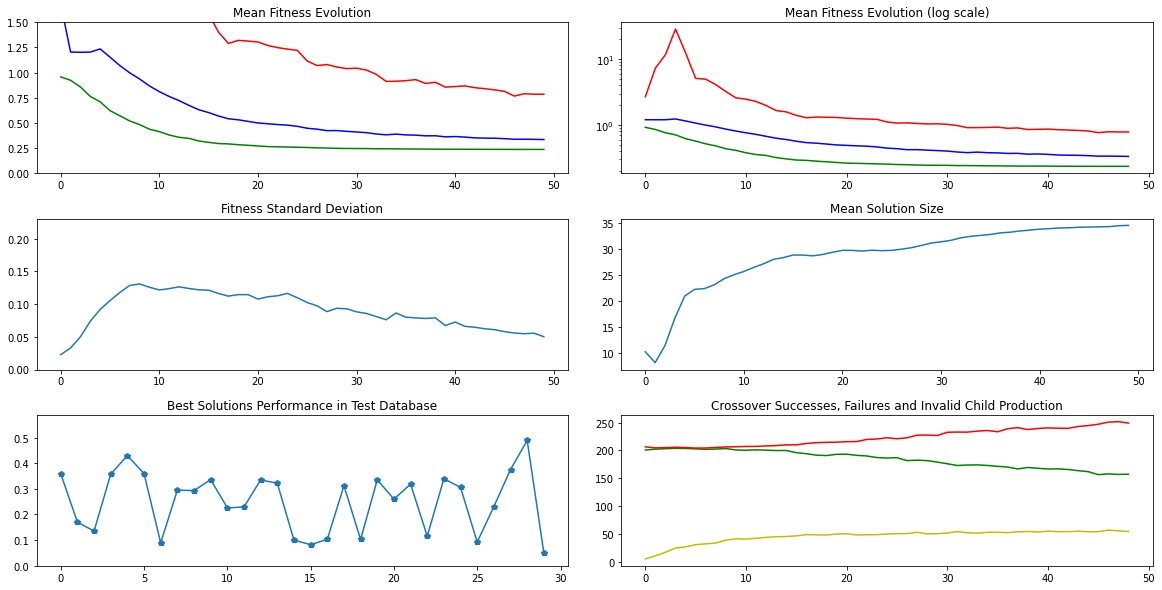

In [ ]:
trainAndTest(30, 500, 7, 50, 0.3, 0.7, 5, False, 0.01, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.12795434268762218

Média das melhores soluções:0.260301000369073

Melhor Solução encontrada para cada geração:
(((X1*(X1*X1))-((X2+-0.960287731901875)-(X1*(X1*(X1*X1)))))+sin((((X2+-0.31497440607236693)*((X1+X1)/(X1*-0.31497440607236693)))+((0.7037837149468675/(0.17192094853548/-0.31497440607236693))+(X2-cos(-0.31497440607236693))))))
(((((X1*sin(X1))+-0.5956947710877436)+sin(((X1*X1)+-0.5956947710877436)))-(0.4429896457935605/((X1*X1)+(0.8212836680789921/sin(-0.5956947710877436)))))+((X1*(((0.8212836680789921/-0.4296643611456823)+(-0.14716172106954906-0.9961518736969024))-((X1*X1)+sin(X1))))-(0.4429896457935605/(0.4429896457935605/((X1*X1)+sin(-0.4296643611456823))))))
(X1*((((0.8855351608111046-cos(X1))+(X1+X1))+((0.8855351608111046-cos(X1))+(X1+(X1+X1))))+((0.160800528013054+(0.160800528013054+0.8594754199083192))-(0.8855351608111046-X1))))
(X2-((-0.5607649824188634-(-0.5607649824188634-0.0010456798393227995))+((0.036599049786528726+(X1*X1))*(X

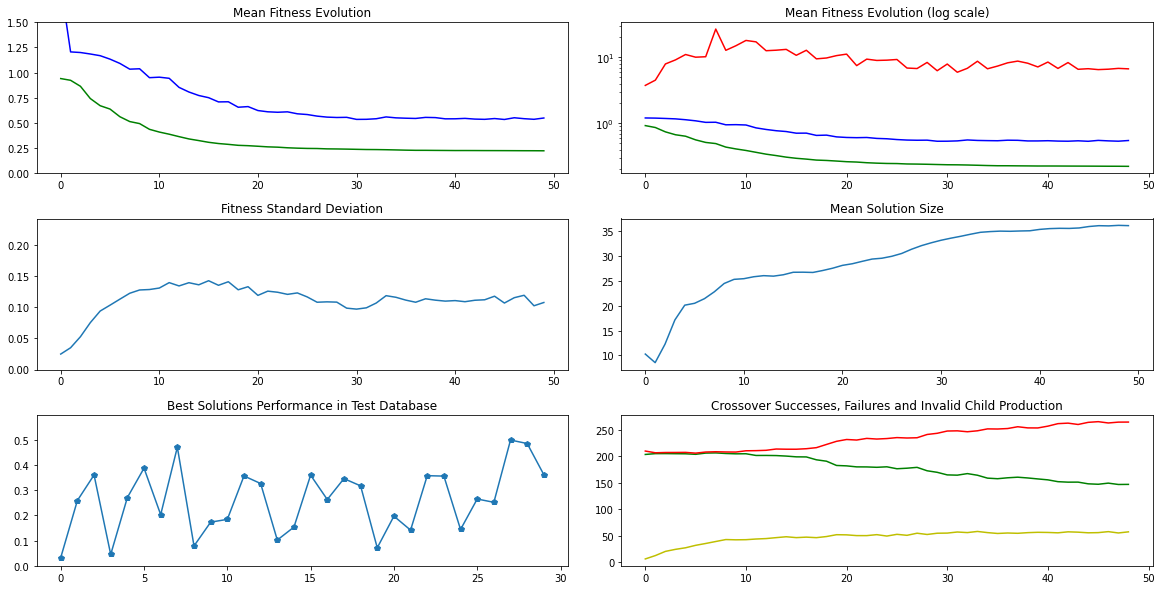

In [ ]:
trainAndTest(30, 500, 7, 50, 0.3, 0.7, 5, False, 0, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.115276629176954

Média das melhores soluções:0.17307157015133506

Melhor Solução encontrada para cada geração:
(((-0.178530755982941-(((X1-0.7805208131340466)*cos(X1))*(X1+(0.25703415558135845/X1))))-X1)-(-0.18145268219026756-(-0.178530755982941-(((X1-0.7805208131340466)*sin(-0.8024454295252841))*(0.25703415558135845/X1)))))
(((X2+((X1*X1)*(sin(-0.2818644948262323)/cos(X1))))+((-0.5174497973878927/cos(cos(X1)))+((X2+-0.5174497973878927)*(-0.6228106184746307+sin(-0.2818644948262323)))))+((0.08808738700647978/(0.3304404966055434*((0.8179935615819789+X1)-cos(-0.021061643872452684))))*((-0.422768761359392-X1)-(cos(0.6059288626697539)+cos(sin(X1))))))
((X1+(X1+(X1+(X1+X1))))-((0.6674045702857645/((X2-X2)/cos((X1+X1))))+(((X2-X2)/cos((X1+X1)))+((X1+X1)*(X1+(X1+X1))))))
(cos(cos(((X1-(X1+0.49014247216171536))+((0.8996002269102805+X1)-0.49014247216171536))))/(X1-((0.23842583523780791/(X1*X1))+(((X1+X1)-(X1+0.026282357647513965))+(X1-0.07379803753551561)))

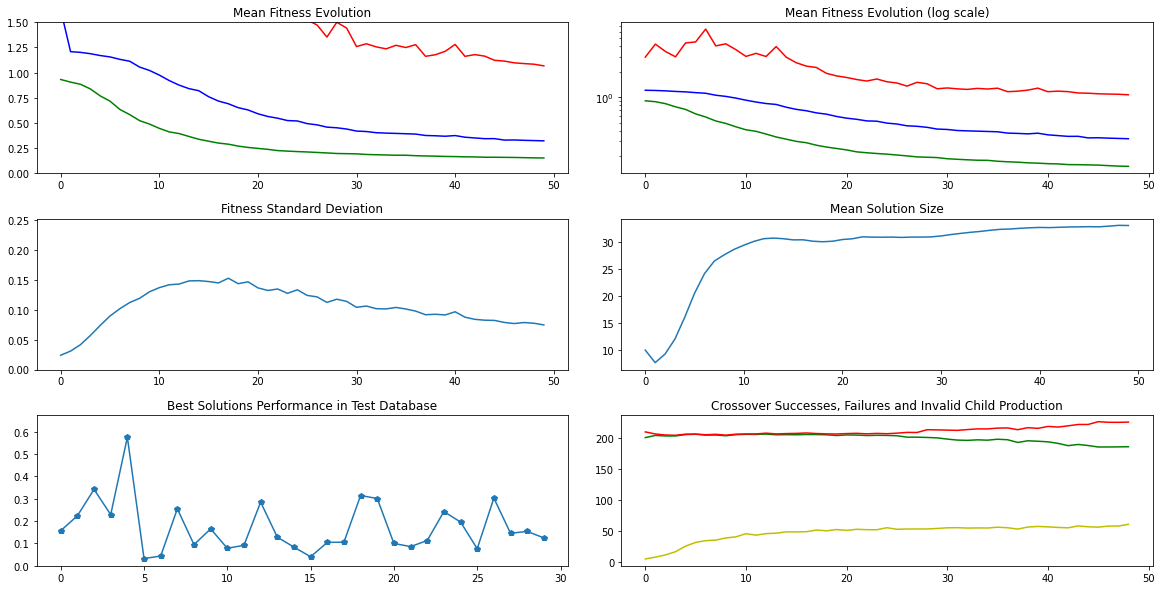

In [ ]:
trainAndTest(30, 500, 7, 50, 0.3, 0.7, 3, False, 3/500, "synth1-train.csv", "synth1-test.csv")

Desvio padrão para melhores soluções:0.12711956316018244

Média das melhores soluções:0.2130228937590078

Melhor Solução encontrada para cada geração:
((((0.35002847868268083/X1)-(X1-cos((X1+X1))))+cos((X1-X1)))*(X1*((X2/X2)-sin((X1+cos(0.30999747400141775))))))
(((-0.7423800188261482/X1)+((-0.7423800188261482/(-0.7423800188261482/sin(X1)))+(0.15640369809246168+(0.15640369809246168+(X1*X1)))))*((X1*X1)+sin(((-0.7423800188261482/X1)+sin(sin(X1))))))
((((-0.4994631784552128/X1)-(X2-(-0.4994631784552128/(-0.4994631784552128/X1))))*((-0.05278399696501479+X1)-sin((X1+sin(-0.5447448803721657)))))-((((0.2669458294505307+sin(X1))-(X1+(-0.17137596451675852+X1)))*((-0.05278399696501479+X1)-cos((0.2669458294505307+-0.18282715781826053))))-(-0.4994631784552128/cos(sin((-0.4994631784552128/-0.43478776842645894))))))
((((X1*(X1-0.11287130436604143))*(X1*(X1-0.9163600180129332)))+(X2-cos(((X1-0.9163600180129332)/(X1*0.11287130436604143)))))+(sin(((X1-0.1315255492845604)/0.11287130436604143))*0.916360

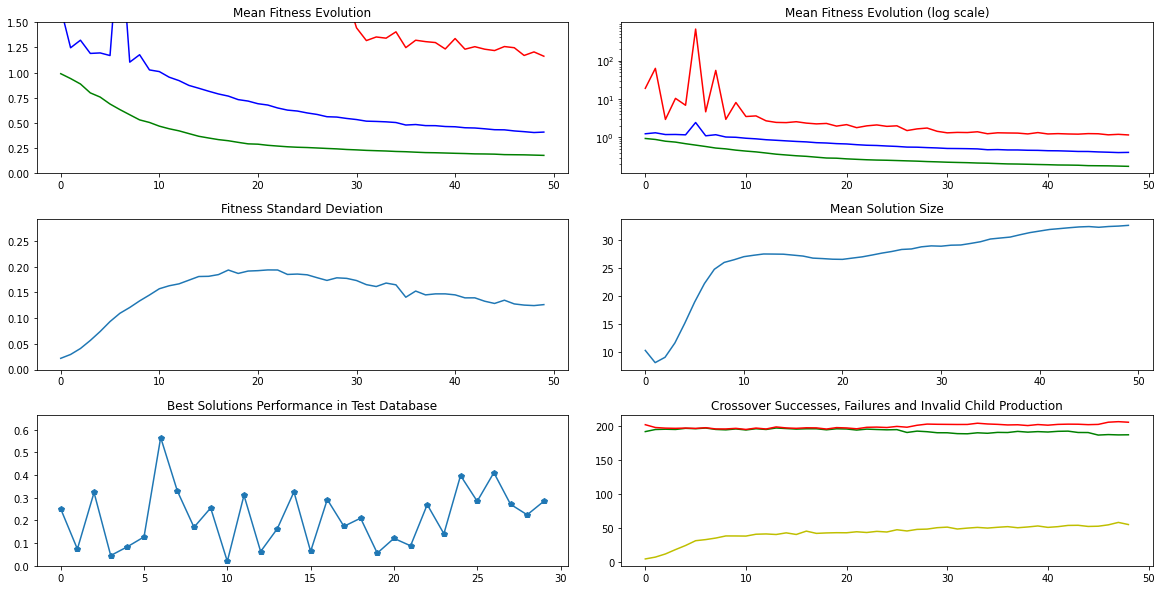

In [ ]:
trainAndTest(30, 500, 7, 50, 0.25, 0.65, 3, False, 3/500, "synth1-train.csv", "synth1-test.csv")

##Comparação com geração aleatória

Desvio padrão para melhores soluções:0.16031343961686206

Média das melhores soluções:0.6789881227273152

Melhor Solução encontrada para cada geração:
((((cos(cos(0.797693783630572))-cos((X1-0.1380163191949264)))*(((X1/0.390956589042895)/(X1-0.4434575054002441))+cos((-0.7153569103486157+0.6930966291601295))))-((((-0.5441799327279433-X2)/(0.6789400917436417/X2))-((X1*X1)+(X1--0.8990724286571365)))/(((X1*0.7957004452593657)*(-0.9264073569144369/X1))-sin((0.8252625713575583/X1)))))-(cos(sin(sin((-0.5426237044534106-X1))))*cos(((cos(-0.7095827412187092)/(X1/-0.24012309394362563))/((0.18879489744939004-X2)+(X2*0.9970222496219896))))))
((sin(((X1/-0.3977263121262786)*(0.07532722153023275+-0.3639958989925456)))*cos((sin(-0.14359920765588208)/cos(-0.4760357064660885))))/(((sin(0.8722597894369544)/(-0.40273491911156123+X1))+cos((X1*-0.7826108049030664)))*sin(cos((0.6528707189622249-0.849797783688033)))))
((sin(X1)-(-0.28427530564868153*X1))+((-0.263221466928375/X1)*(X1-0.974140219524819)))
(((c

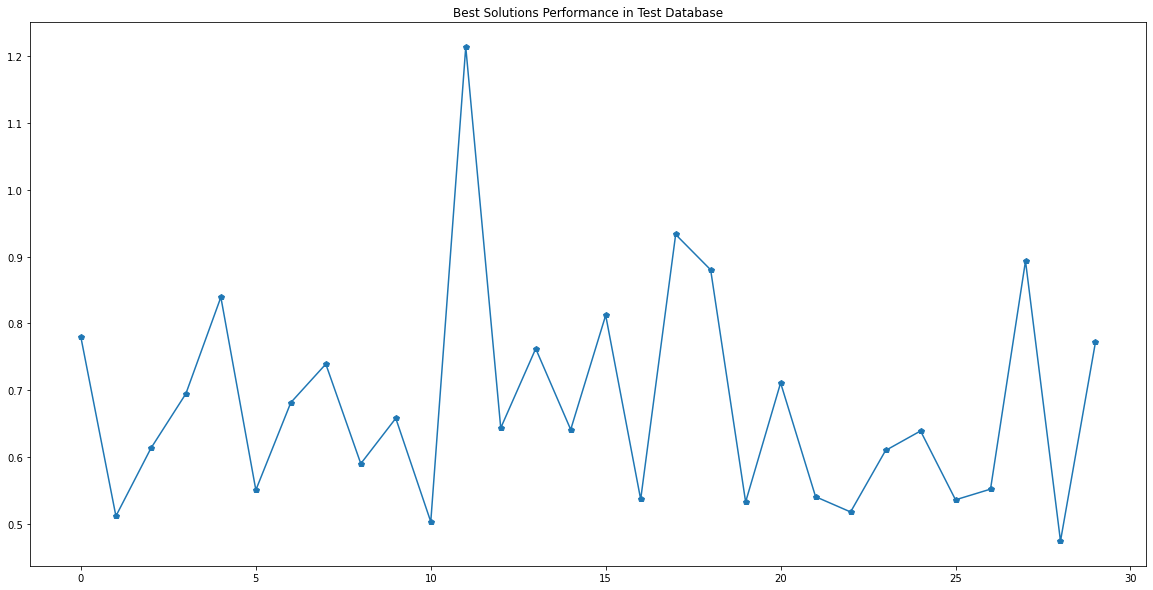

In [ ]:
trainAndTest(30, 10000, 7, 1, 0.0, 0.0, 0, False, 0, "synth1-train.csv", "synth1-test.csv")

## Evolução do melhor indivíduo em um teste

(((0.6263263879831464/X1)/(0.249242568794263*X2))+((X1-X2)*(-0.5967477293281243/X1)))
(((0.6263263879831464/X1)/(0.249242568794263*X2))+((X1-X2)*(-0.5967477293281243/X1)))
(cos(cos((0.0068893436377219786/0.5528866837180613)))+((X1-X2)*(-0.5967477293281243/X1)))
(cos(cos((0.0068893436377219786/0.5528866837180613)))+((X1-X2)*(-0.5967477293281243/X1)))
((X2/X2)/(((0.04337606056390286+X1)*(0.43217716328544764+X1))*((-0.33010227537069436*X2)+(-0.8078938056282174-(-0.38203209546489547-(0.7817887774682022+0.7435401563926392))))))
((0.0068893436377219786/0.5528866837180613)/(((0.04337606056390286+X1)*(0.43217716328544764+X1))*((-0.33010227537069436*-0.970636062344697)+(-0.8078938056282174-0.9913147694483007))))
((0.0068893436377219786/0.5528866837180613)/(((0.04337606056390286+X1)*(0.43217716328544764+X1))*((-0.33010227537069436*-0.970636062344697)+(-0.8078938056282174-0.9913147694483007))))
((0.0068893436377219786/0.5528866837180613)/(((0.04337606056390286+X1)*(0.43217716328544764+X1))*((-0.3

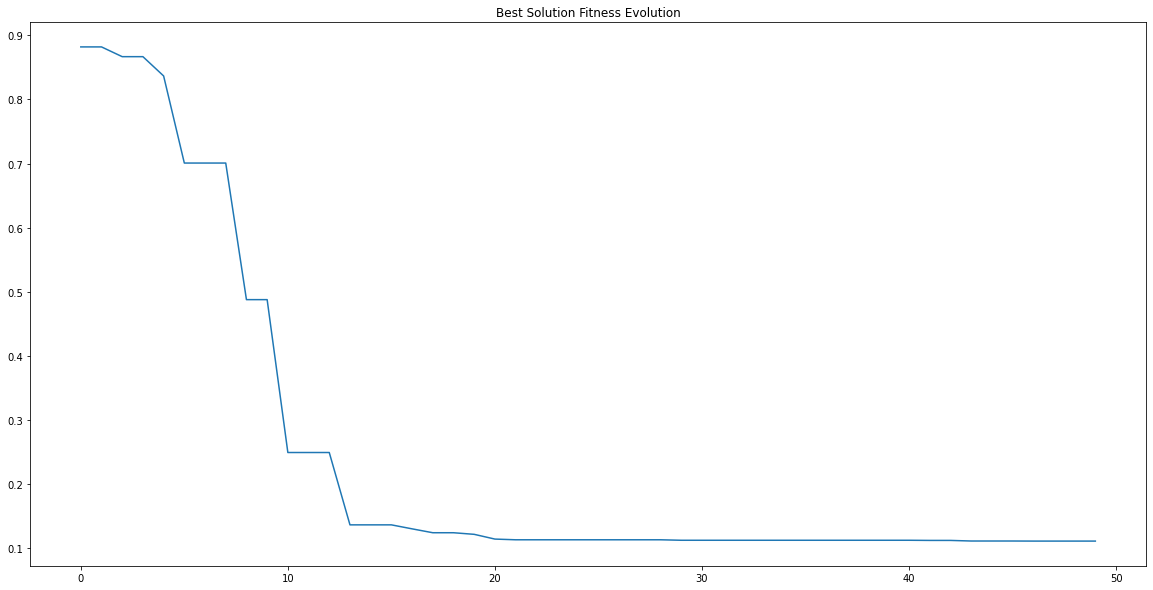

In [ ]:
bestSolutionFit, meanSolutionFit, worstSolutionFit, best, crossoverSuccess, crossoverFailure, invalidChildEvo, diversity, meanSize = runAlg(500, 7, 50, 0.3, 0.7, 3, False, 3/500, "synth1-train.csv")
for solution in bestSolutionFit:
  print_tree(solution.tree)
plt.title("Best Solution Fitness Evolution")
plt.plot([solution.fitness for solution in bestSolutionFit])

## Base Sintética 2

Desvio padrão para melhores soluções:0.21588626770899216

Média das melhores soluções:0.7196214087176149

Melhor Solução encontrada para cada geração:
(((((X2-0.7262067596207429)+(0.11376005261308708*(X2+X2)))+(0.20014663153402945*(X1*X2)))*(cos(((X2-X1)-0.008745370104527694))-(((0.11376005261308708*X2)-sin(X2))*(cos(-0.11814322099735186)/cos(0.3779025705648513)))))-(cos((X1+(X2+X2)))-(sin(X1)*((X2-cos(-0.11814322099735186))+(0.3827156550726014/cos(0.03048553912053298))))))
((((0.2691143329095509--0.7953034719190222)-cos((X2-sin(X1))))*(cos(((X1-X2)*0.44179336659344814))--0.7953034719190222))-(((X1-X2)-sin(sin((X2-X2))))*sin((sin(X2)-sin(X1)))))
((cos((0.0308548375529778+(X2-X1)))+sin((X1+((0.2545528303135647*X1)-(-0.9016238922522977+X2)))))+(sin(((sin(0.8075660254052195)/sin(X1))+((0.2545528303135647*X2)-(-0.9016238922522977+X2))))+sin(((0.4497963126546878/sin(X1))+((0.2545528303135647*X2)-(-0.9016238922522977+X2))))))
(((0.2661052697345945+0.40185065806340603)/sin(((-0.61186366706352

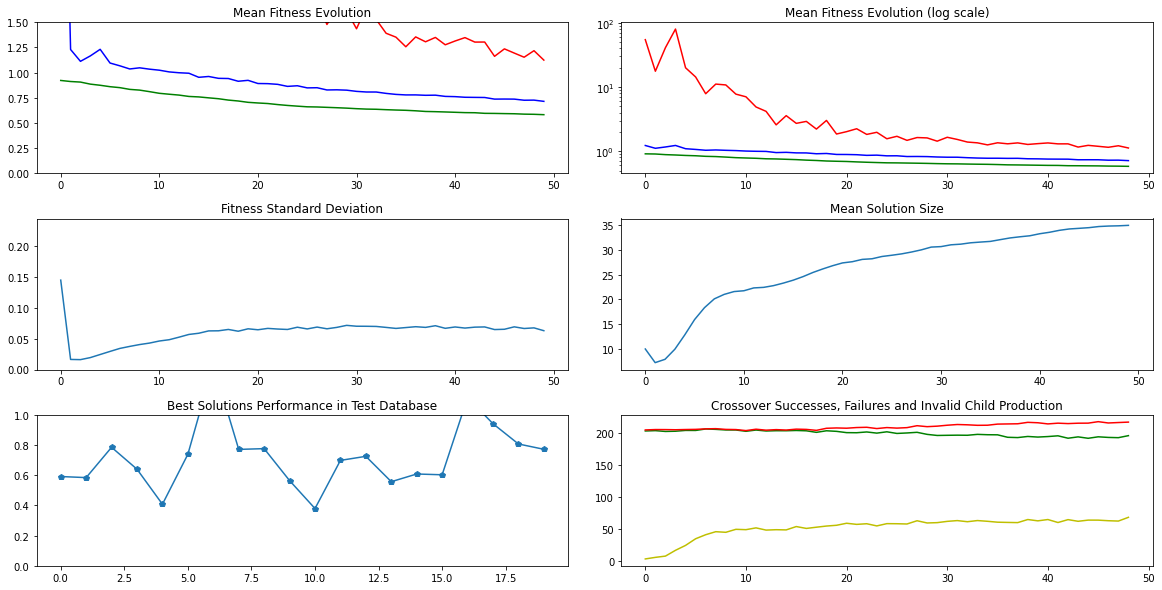

In [ ]:
trainAndTest(20, 500, 7, 50, 0.3, 0.7, 3, False, 3/500, "synth2-train.csv", "synth2-test.csv")

Desvio padrão para melhores soluções:0.08855849657192917

Média das melhores soluções:0.9057782821454193

Melhor Solução encontrada para cada geração:
(sin(sin(0.291745183347907))/cos((X1-X2)))
(sin(sin(((sin(X1)*cos(0.3837551642121093))+((-0.900560494465221/0.20617003465701278)-cos(-0.4380225056882865)))))/sin(cos((((X2/-0.2384585619083568)+(X2-X1))*sin(cos(0.4668284043849369))))))
((sin(X2)*(0.48902639357073974-X1))-(sin(X2)*(X1/0.8689142563778454)))
(((cos(sin(-0.7021045371783929))*((-0.17548588461350345-0.735286904195215)+(X1*-0.4960028067479565)))*(((X1+0.744288368925164)+(-0.6206648971916302+0.992251003911985))-(sin(0.9925621412053927)+sin(X2))))*cos((cos((-0.8718312315796009/-0.08799030100251648))+((0.6766050853795205*X2)+(X1-0.11594561315512308)))))
((X1-X2)*sin(X2))
cos(((X1-X2)*-0.8748534844303479))
((X2-X1)*cos((-0.5108086416357347-(0.5702134778093537+X2))))
(((cos(X2)-(X1+-0.48396475699983954))-((-0.467747173059164*X2)*(X1*-0.8830801746487313)))*sin(cos((0.8061273971536995+

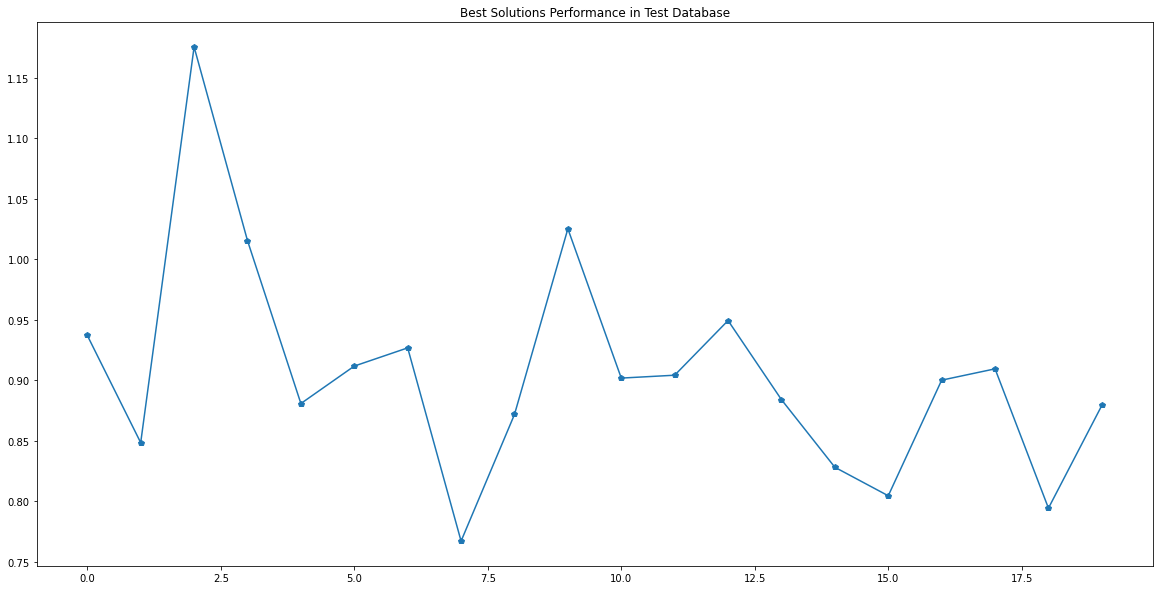

In [ ]:
trainAndTest(20, 10000, 7, 1, 0.0, 0.0, 0, False, 0, "synth2-train.csv", "synth2-test.csv")

## Base concreta

Desvio padrão para melhores soluções:0.10357106868842718

Média das melhores soluções:0.8455923664065246

Melhor Solução encontrada para cada geração:
(X5+(cos((-0.31877257570193596*((0.9149774564451103-X5)*(0.7837743413605684+X5))))-(sin(X5)-(0.023176917583739742/(-0.64258639669479-(0.9989767267607836+-0.963690550099974))))))
(((X4*0.06141692715366176)-sin(((cos(0.324307023897936)*(X4*0.06141692715366176))-cos(0.324307023897936))))-(sin((X4*(-0.8082968655232909/0.06141692715366176)))+(sin((X5+(X4*0.06141692715366176)))+(0.694054794445595/(X5+(X4*0.06141692715366176))))))
((X5-((0.8055208684880049+((0.32575957566147307+0.604261441729727)-0.07665676514554431))/(0.32575957566147307+0.07665676514554431)))-(((0.8055208684880049+((0.32575957566147307+0.604261441729727)-0.07665676514554431))/cos(-0.10130164770119121))-cos((0.08961463819870819+cos(-0.10130164770119121)))))
(((sin(-0.18008800524288793)/((0.609242990384655--0.4057507289921216)-cos((X8/X5))))+((0.08564955971183719+((-0.965537615

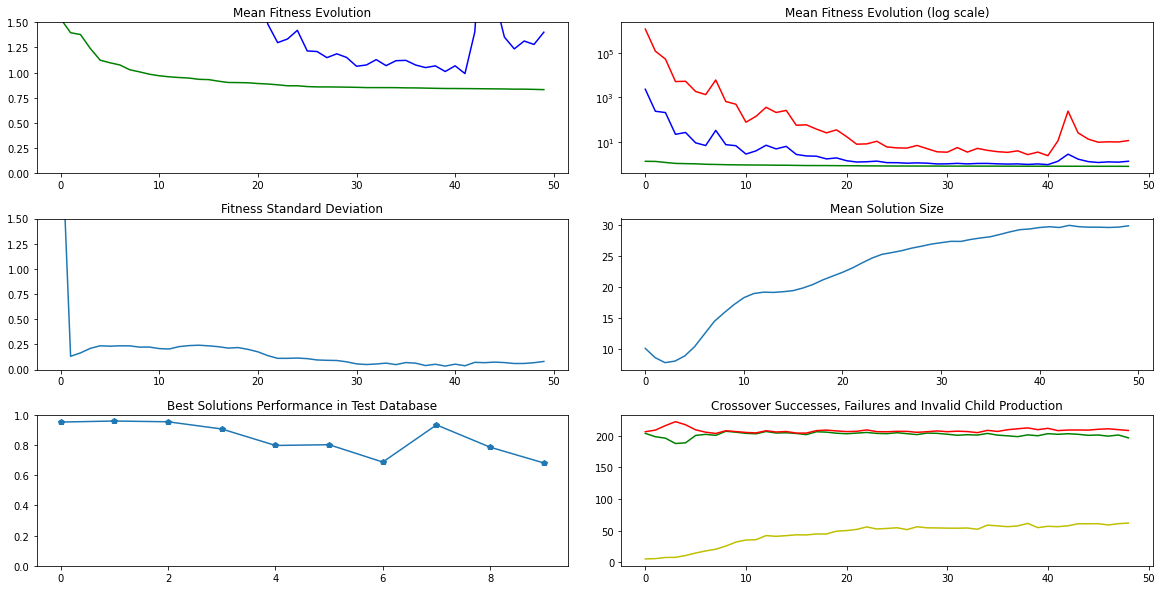

In [ ]:
trainAndTest(10, 500, 7, 50, 0.3, 0.7, 3, False, 3/500, "concrete-train.csv", "concrete-test.csv")

Desvio padrão para melhores soluções:0.08112989326405727

Média das melhores soluções:0.9755323084695989

Melhor Solução encontrada para cada geração:
(X1*0.15291705759750807)
(0.8665302269838928-((X1-(X5--0.751620134088228))*-0.12121640619038976))
(X1*0.14617633632268157)
(((0.13515059426195153*-0.22458087287511708)*(0.7602261007218636+0.6500923137264389))*((0.25027833011255884*0.8590734449854982)+(-0.9245631277540551/X7)))
(cos(sin(-0.4424286770166648))-((-0.8925966288287814--0.7353369677002037)-(0.12960137832831253*X1)))
((0.7803889480593342*0.11635480471796922)*X1)
((sin(-0.34970289975423596)+(X7/X8))+((0.4419989975402021-0.4904042800681332)/(X4/X1)))
((X1+cos(cos(0.7292899022997199)))*0.11182717319897884)
((X5+-0.573602905884367)+(X4*0.17562207666521523))
(-0.18441905366919453-((0.9489233795280205/X1)*sin(0.10382254901177324)))

Dados:



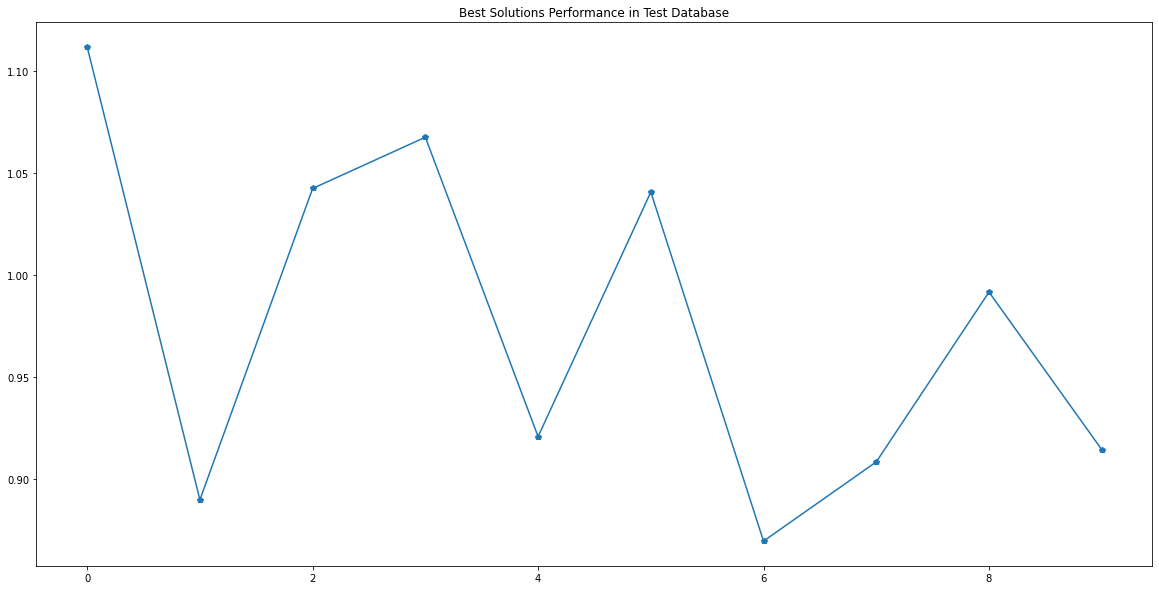

In [ ]:
trainAndTest(10, 10000, 7, 1, 0.0, 0.0, 0, False, 0, "concrete-train.csv", "concrete-test.csv")

# **4 - Conclusão**

Esse trabalho teve como objetivo implementar uma solução para o problema da regressão simbólica utilizando programação genética e, principalmente, analisar como os parâmetros podem alterar o resultado final. Em especial, observamos como idéias muito atrativas a princípio, como o elitismo dos operadores no nosso caso, podem não ser muito interessantes em algumas instâncias. Vemos também que algumas mudanças significativas não produzem o efeito esperado como no caso da alteração das taxas de cruzamento e mutação.

  Por fim, vemos como muitas vezes bases diferentes requerem parâmetros diferentes e como é difícil encontrar boas aproximações para bases de dados grandes e com várias variáveis. Essa dificuldade reside principalmente na necessidade de um grande número de testes que se fazem cada vez mais custosos a medida que a base de dados aumenta. Para ilustrar, enquanto na base sintética 1, gastava-se aproximadamente 11 minutos para executar os 30 treinos, para a base sintética 2 gastou-se 34 minutos para 20 e para a real 44 minutos para somente 10. Além disso observa-se que não o modelo proposto pode funcionar para uma base de dados e ser absolutamente ineficiente em outra mas, para concluirmos isso no nosso caso em específico, precisaríamos ter executado muitos outros testes nas outras bases, a procura de parâmetros mais interessantes.


# Bibliografia


*   http://www.gp-field-guide.org.uk/
*   https://matplotlib.org/stable/api/index.html

